In [1]:
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)

## Import Dependencies

In [1]:
#file
import json
import xml.etree.ElementTree as ET
import os

#data science
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

#images
from PIL import Image
import cv2
import h5py
from skimage import util
from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
# from skimage.measure import compare_psnr updated to peak_signal_noise_ratio
# from skimage.measure import compare_ssim updated to structural_similarity

#stats
import math 
import random
import scipy.io as sio
import scipy
from scipy.ndimage import gaussian_filter, morphology

#torch modules
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR, MultiStepLR

#model
from sklearn import linear_model

#time
import argparse
from time import time

## Adjust And Format Image Files

In [2]:
def read_image(x):
    img_arr = np.array(Image.open(x))
    if len(img_arr.shape) == 2:  # grayscale
        img_arr = np.tile(img_arr, [3, 1, 1]).transpose(1, 2, 0)
    return img_arr

In [3]:
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):

        image, target, gtcount = sample['image'], sample['target'], sample['gtcount']
        h, w = image.shape[:2]

        if isinstance(self.output_size, tuple):
            new_h = min(self.output_size[0], h)
            new_w = min(self.output_size[1], w)
            assert (new_h, new_w) == self.output_size
        else:
            crop_size = min(self.output_size, h, w)
            assert crop_size == self.output_size
            new_h = new_w = crop_size
        if gtcount > 0:
            mask = target > 0
            ch, cw = int(np.ceil(new_h / 2)), int(np.ceil(new_w / 2))
            mask_center = np.zeros((h, w), dtype=np.uint8)
            mask_center[ch:h-ch+1, cw:w-cw+1] = 1
            mask = (mask & mask_center)
            idh, idw = np.where(mask == 1)
            if len(idh) != 0:
                ids = random.choice(range(len(idh)))
                hc, wc = idh[ids], idw[ids]
                top, left = hc-ch, wc-cw
            else:
                top = np.random.randint(0, h-new_h+1)
                left = np.random.randint(0, w-new_w+1)
        else:
            top = np.random.randint(0, h-new_h+1)
            left = np.random.randint(0, w-new_w+1)

        image = image[top:top+new_h, left:left+new_w, :]
        target = target[top:top+new_h, left:left+new_w]

        return {'image': image, 'target': target, 'gtcount': gtcount}

In [4]:
class RandomFlip(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        image, target, gtcount = sample['image'], sample['target'], sample['gtcount']
        do_mirror = np.random.randint(2)
        if do_mirror:
            image = cv2.flip(image, 1)
            target = cv2.flip(target, 1)
        return {'image': image, 'target': target, 'gtcount': gtcount}

In [5]:
class Normalize(object):

    def __init__(self, scale, mean, std):
        self.scale = scale
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, target, gtcount = sample['image'], sample['target'], sample['gtcount']
        image, target = image.astype('float32'), target.astype('float32')

        # pixel normalization
        image = (self.scale * image - self.mean) / self.std

        image, target = image.astype('float32'), target.astype('float32')

        return {'image': image, 'target': target, 'gtcount': gtcount}

In [6]:
class ZeroPadding(object):
    def __init__(self, psize=32):
        self.psize = psize

    def __call__(self, sample):
        psize =  self.psize

        image, target, gtcount = sample['image'], sample['target'], sample['gtcount']
        h,w = image.size()[-2:]
        ph,pw = (psize-h%psize),(psize-w%psize)
        print(ph,pw)

        (pl, pr) = (pw//2, pw-pw//2) if pw != psize else (0, 0)
        (pt, pb) = (ph//2, ph-ph//2) if ph != psize else (0, 0)
        if (ph!=psize) or (pw!=psize):
            tmp_pad = [pl, pr, pt, pb]
            print(tmp_pad)
            image = F.pad(image,tmp_pad)
            target = F.pad(target,tmp_pad)

        return {'image': image, 'target': target, 'gtcount': gtcount}

In [7]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self):
        pass

    def __call__(self, sample):
        # swap color axis
        # numpy image: H x W x C
        # torch image: C X H X W
        image, target, gtcount = sample['image'], sample['target'], sample['gtcount']
        image = image.transpose((2, 0, 1))
        target = np.expand_dims(target, axis=2)
        target = target.transpose((2, 0, 1))
        image, target = torch.from_numpy(image), torch.from_numpy(target)
        return {'image': image, 'target': target, 'gtcount': gtcount}

In [8]:
class MaizeTasselDataset(Dataset):
    def __init__(self, data_dir, data_list, ratio, train=True, transform=None):
        self.data_dir = data_dir
        self.data_list = [name.split('\t') for name in open(data_list).read().splitlines()]
        self.ratio = ratio
        self.train = train
        self.transform = transform
        self.image_list = []
        
        # store images and generate ground truths
        self.images = {}
        self.targets = {}
        self.gtcounts = {}
        self.dotimages = {}

    def bbs2points(self, bbs):    
        points = []
        for bb in bbs:
            x1, y1, w, h = [float(b) for b in bb]
            x2, y2 = x1+w-1, y1+h-1
            x, y = np.round((x1+x2)/2).astype(np.int32), np.round((y1+y2)/2).astype(np.int32)
            points.append([x, y])
        return points

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        file_name = self.data_list[idx]
        self.image_list.append(file_name[0])
        if file_name[0] not in self.images:
            image = read_image(self.data_dir+file_name[0])
            annotation = sio.loadmat(self.data_dir+file_name[1])
            h, w = image.shape[:2]
            nh = int(np.ceil(h * self.ratio))
            nw = int(np.ceil(w * self.ratio))
            image = cv2.resize(image, (nw, nh), interpolation = cv2.INTER_CUBIC)
            target = np.zeros((nh, nw), dtype=np.float32)
            dotimage = image.copy()
            if annotation['annotation'][0][0][1] is not None:
                bbs = annotation['annotation'][0][0][1]
                gtcount = bbs.shape[0]
                pts = self.bbs2points(bbs)
                for pt in pts:
                    pt[0], pt[1] = int(pt[0] * self.ratio), int(pt[1] * self.ratio)
                    target[pt[1], pt[0]] = 1
                    cv2.circle(dotimage, (pt[0], pt[1]), int(24 * self.ratio) , (255, 0, 0), -1)
            else:
                gtcount = 0
            target = gaussian_filter(target, 80 * self.ratio)

            #plt.imshow(target, cmap=cm.jet)
            #plt.show()
            print(target.sum())

            self.images.update({file_name[0]:image})
            self.targets.update({file_name[0]:target})
            self.gtcounts.update({file_name[0]:gtcount})
            self.dotimages.update({file_name[0]:dotimage})

        
        sample = {
            'image': self.images[file_name[0]], 
            'target': self.targets[file_name[0]], 
            'gtcount': self.gtcounts[file_name[0]]
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

## Build Data Loader

In [10]:
dataset = MaizeTasselDataset(
        data_dir='maize_counting_dataset', 
        data_list='maize_counting_dataset/train.txt',
        ratio=0.167, 
        train=True, 
        transform=transforms.Compose([
            ToTensor()]
        )
    )

In [11]:
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )

In [12]:
print(len(dataloader))
mean = 0.
std = 0.
for i, data in enumerate(dataloader, 0):
        images, targets = data['image'], data['target']
        bs = images.size(0)
        images = images.view(bs, images.size(1), -1).float()
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        print(f"index = {i} size = {images.size()}")
mean /= len(dataloader)
std /= len(dataloader)
print(mean/255.)
print(std/255.)

186
96.999985
index = 0 size = torch.Size([1, 3, 278770])
39.999996
index = 1 size = torch.Size([1, 3, 278770])
22.999998
index = 2 size = torch.Size([1, 3, 278770])
44.0
index = 3 size = torch.Size([1, 3, 278770])
32.0
index = 4 size = torch.Size([1, 3, 278770])
49.000004
index = 5 size = torch.Size([1, 3, 222530])
40.999992
index = 6 size = torch.Size([1, 3, 278770])
60.000004
index = 7 size = torch.Size([1, 3, 222530])
32.000004
index = 8 size = torch.Size([1, 3, 278770])
41.999996
index = 9 size = torch.Size([1, 3, 278770])
66.0
index = 10 size = torch.Size([1, 3, 278770])
65.99999
index = 11 size = torch.Size([1, 3, 278770])
63.0
index = 12 size = torch.Size([1, 3, 278770])
24.0
index = 13 size = torch.Size([1, 3, 278770])
39.999992
index = 14 size = torch.Size([1, 3, 278770])
36.000004
index = 15 size = torch.Size([1, 3, 278770])
42.0
index = 16 size = torch.Size([1, 3, 278770])
49.99999
index = 17 size = torch.Size([1, 3, 278770])
66.0
index = 18 size = torch.Size([1, 3, 278770]

40.000004
index = 155 size = torch.Size([1, 3, 278770])
5.0
index = 156 size = torch.Size([1, 3, 278770])
64.0
index = 157 size = torch.Size([1, 3, 278770])
120.0
index = 158 size = torch.Size([1, 3, 278770])
70.0
index = 159 size = torch.Size([1, 3, 278770])
60.999996
index = 160 size = torch.Size([1, 3, 278770])
24.000002
index = 161 size = torch.Size([1, 3, 222530])
66.00001
index = 162 size = torch.Size([1, 3, 278770])
0.0
index = 163 size = torch.Size([1, 3, 278770])
62.999996
index = 164 size = torch.Size([1, 3, 278770])
37.999992
index = 165 size = torch.Size([1, 3, 278770])
16.000002
index = 166 size = torch.Size([1, 3, 278770])
1.0
index = 167 size = torch.Size([1, 3, 278770])
16.0
index = 168 size = torch.Size([1, 3, 278770])
21.999994
index = 169 size = torch.Size([1, 3, 278770])
0.0
index = 170 size = torch.Size([1, 3, 278770])
40.0
index = 171 size = torch.Size([1, 3, 278770])
0.0
index = 172 size = torch.Size([1, 3, 278770])
14.000001
index = 173 size = torch.Size([1, 3, 

## Computation Functions

In [9]:
def compute_mae(pd, gt):
    pd, gt = np.array(pd), np.array(gt)
    diff = pd - gt
    mae = np.mean(np.abs(diff))
    return mae


def compute_mse(pd, gt):
    pd, gt = np.array(pd), np.array(gt)
    diff = pd - gt
    mse = np.sqrt(np.mean((diff ** 2)))
    return mse

def compute_relerr(pd, gt):
    pd, gt = np.array(pd), np.array(gt)
    diff = pd - gt
    diff = diff[gt > 0]
    gt = gt[gt > 0]
    if (diff is not None) and (gt is not None):
        rmae = np.mean(np.abs(diff) / gt) * 100
        rmse = np.sqrt(np.mean(diff**2 / gt**2)) * 100
    else:
        rmae = 0
        rmse = 0
    return rmae, rmse


def rsquared(pd, gt):
    """ Return R^2 where x and y are array-like."""
    pd, gt = np.array(pd), np.array(gt)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pd, gt)
    return r_value**2


def dense_sample2d(x, sx, stride):
    (h,w) = x.shape[:2]
    #idx_img = np.array([i for i in range(h*w)]).reshape(h,w)
    idx_img = np.zeros((h,w),dtype=float)
    
    th = [i for i in range(0, h-sx+1, stride)]
    tw = [j for j in range(0, w-sx+1, stride)]
    norm_vec = np.zeros(len(th)*len(tw))

    for i in th:
        for j in tw:
            idx_img[i:i+sx,j:j+sx] = idx_img[i:i+sx,j:j+sx]+1

    # plot redundancy map
    import os
    import matplotlib.pyplot as plt
    cmap = plt.cm.get_cmap('hot')
    idx_img = idx_img / (idx_img.max())
    idx_img = cmap(idx_img) * 255.
    plt.figure()
    plt.imshow(idx_img.astype(np.uint8))
    plt.axis('off')
    plt.savefig(os.path.join('redundancy_map.pdf'), bbox_inches='tight', dpi = 300)
    plt.close()
   
    idx_img = 1/idx_img
    idx_img = idx_img/sx/sx
    #line order
    idx = 0
    for i in th:
        for j in tw:
            norm_vec[idx] =idx_img[i:i+sx,j:j+sx].sum()
            idx+=1
    
    return norm_vec


def recover_countmap(pred, image, patch_sz, stride):
    pred = pred.reshape(-1)
    imH, imW = image.shape[2:4]
    cntMap = np.zeros((imH, imW), dtype=float)
    norMap = np.zeros((imH, imW), dtype=float)
    
    H = np.arange(0, imH - patch_sz + 1, stride)
    W = np.arange(0, imW - patch_sz + 1, stride)
    cnt = 0
    for h in H:
        for w in W:
            pixel_cnt = pred[cnt] / patch_sz / patch_sz
            cntMap[h:h+patch_sz, w:w+patch_sz] += pixel_cnt
            norMap[h:h+patch_sz, w:w+patch_sz] += np.ones((patch_sz,patch_sz))
            cnt += 1
    return cntMap / (norMap + 1e-12)

## Building the Model

In [10]:
class Encoder(nn.Module):
    def __init__(self, arc='tasselnetv2'):
        super(Encoder, self).__init__()
        if arc == 'tasselnetv2':
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 16, 3, padding=1, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),
                nn.MaxPool2d((2, 2), stride=2),
                nn.Conv2d(16, 32, 3, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d((2, 2), stride=2),
                nn.Conv2d(32, 64, 3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d((2, 2), stride=2),
                nn.Conv2d(64, 128, 3, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, 3, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
            )
        else:
            raise NotImplementedError

    def forward(self, x):
        x = self.encoder(x)
        return x

In [11]:
class Counter(nn.Module):
    def __init__(self, arc='tasselnetv2', input_size=64, output_stride=8):
        super(Counter, self).__init__()
        k = int(input_size / 8)
        avg_pool_stride = int(output_stride / 8)

        if arc == 'tasselnetv2':
            self.counter = nn.Sequential(
                nn.Conv2d(128, 128, (k, k), bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 1, 1)
            )
        else:
            raise NotImplementedError

    def forward(self, x):
        x = self.counter(x)
        return x

In [12]:
class Normalizer:
    @staticmethod
    def cpu_normalizer(x, imh, imw, insz, os):
        # CPU normalization
        bs = x.size()[0]
        normx = np.zeros((imh, imw))
        norm_vec = dense_sample2d(normx, insz, os).astype(np.float32)
        x = x.cpu().detach().numpy().reshape(bs, -1) * norm_vec
        return x
    
    @staticmethod
    def gpu_normalizer(x, imh, imw, insz, os):
        _, _, h, w = x.size()            
        #accm = torch.cuda.FloatTensor(1, insz*insz, h*w).fill_(1)     
        accm = torch.FloatTensor(1, insz*insz, h*w).fill_(1) 
        accm = F.fold(accm, (imh, imw), kernel_size=insz, stride=os)
        accm = 1 / accm
        accm /= insz**2
        accm = F.unfold(accm, kernel_size=insz, stride=os).sum(1).view(1, 1, h, w)
        x *= accm
        return x.squeeze().cpu().detach().numpy()

In [13]:
class CountingModels(nn.Module):
    def __init__(self, arc='tasselnetv2', input_size=64, output_stride=8):
        super(CountingModels, self).__init__()
        self.input_size = input_size
        self.output_stride = output_stride

        self.encoder = Encoder(arc)
        self.counter = Counter(arc, input_size, output_stride)
        if arc == 'tasselnetv2':
          #changed
            self.normalizer = Normalizer.gpu_normalizer
        
        self.weight_init()

    def forward(self, x, is_normalize=True):
        imh, imw = x.size()[2:]
        x = self.encoder(x)
        x = self.counter(x)
        if is_normalize:
            x = self.normalizer(x, imh, imw, self.input_size, self.output_stride)
        return x

    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                # nn.init.kaiming_uniform_(
                #         m.weight, 
                #         mode='fan_in', 
                #         nonlinearity='relu'
                #         )
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [18]:
from time import time

insz, os = 64, 8
imH, imW = 1080, 1920
#net = CountingModels(arc='tasselnetv2', input_size=insz, output_stride=os).cuda()
net = CountingModels(arc='tasselnetv2', input_size=insz, output_stride=os)
with torch.no_grad():
    net.eval()
    #x = torch.randn(1, 3, imH, imW).cuda()
    x = torch.randn(1, 3, imH, imW)
    y = net(x)
    print(y.shape)    

with torch.no_grad():
    frame_rate = np.zeros((100, 1))
    for i in range(100):
        #x = torch.randn(1, 3, imH, imW).cuda()
        x = torch.randn(1, 3, imH, imW)
        #torch.cuda.synchronize()
        start = time()

        y = net(x)

        #torch.cuda.synchronize()
        end = time()

        running_frame_rate = 1 * float(1 / (end - start))
        frame_rate[i] = running_frame_rate
    print(np.mean(frame_rate))

(128, 233)
0.70966386225733


In [19]:
y1 = np.argmax(y, axis=1)
y1

array([232,   0, 232,   0, 232,   0,   0,   0, 232,   0,   0, 232, 232,
         0, 232,   0,   0, 232, 232,   0,   0, 232, 232, 232,   0,   0,
         0, 232,   0,   0, 232, 232, 232,   0,   0, 232, 232,   0,   0,
         0, 232, 232, 232,   0,   0,   0, 232,   0,   0, 232,   0, 232,
       232,   0,   0, 232, 232, 232,   0,   0,   0, 232, 232, 232, 232,
         0, 232,   0, 232, 232, 232,   0, 232,   0,   1, 232,   0,   0,
       232, 232,   0,   0,   0,   0,   0,   0, 232,   0, 232, 232,   0,
         0,   0, 232, 232,   0, 232,   0, 232, 232,   0,   0,   0, 232,
         0, 232,   0, 232, 232,   0, 232,   0, 232,   0,   0, 232, 232,
         0, 232, 232,   0,   0,   0, 232, 232, 232,   0,   0], dtype=int64)

In [20]:
plt.switch_backend('agg')

In [14]:
# prevent dataloader deadlock, uncomment if deadlock occurs
cv2.setNumThreads(0)
#cudnn.enabled = True

# constant
IMG_SCALE = 1. / 255
IMG_MEAN = [.3405, .4747, .2418]
IMG_STD = [1, 1, 1]
SCALES = [0.7, 1, 1.3]
SHORTER_SIDE = 224

# system-related parameters
DATA_DIR = 'maize_counting_dataset'
DATASET = 'mtc'
EXP = 'exp_directory'
DATA_LIST = 'maize_counting_dataset/train.txt'
DATA_VAL_LIST = 'maize_counting_dataset/test.txt'

RESTORE_FROM = 'model_best.pth.tar'
SNAPSHOT_DIR = './snapshots'
RESULT_DIR = './results'

# model-related parameters
INPUT_SIZE = 64
OUTPUT_STRIDE = 8
MODEL = 'tasselnetv2'
RESIZE_RATIO = 0.125

# training-related parameters
OPTIMIZER = 'sgd'  # choice in ['sgd', 'adam']
BATCH_SIZE = 9
CROP_SIZE = (256, 256)
LEARNING_RATE = 1e-2
MILESTONES = [200, 400]
MOMENTUM = 0.95
MULT = 1
NUM_EPOCHS = 25
#NUM_EPOCHS = 500
NUM_CPU_WORKERS = 0
PRINT_EVERY = 1
RANDOM_SEED = 6
WEIGHT_DECAY = 5e-4
VAL_EVERY = 1

device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# add a new entry here if creating a new data loader
dataset_list = {
    'mtc': MaizeTasselDataset
}

In [15]:
def save_checkpoint(state, snapshot_dir, filename='model_ckpt.pth.tar'):
    torch.save(state, '{}/{}'.format(snapshot_dir, filename))


def plot_learning_curves(net, dir_to_save):
    # plot learning curves
    fig = plt.figure(figsize=(16, 9))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(net.train_loss['epoch_loss'], label='train loss', color='tab:blue')
    ax1.legend(loc='upper right')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(net.val_loss['epoch_loss'], label='val mae', color='tab:orange')
    ax2.legend(loc='upper right')
    # ax2.set_ylim((0,50))
    fig.savefig(os.path.join(dir_to_save, 'learning_curves.png'), bbox_inches='tight', dpi=300)
    plt.close()

## Train and Validate Methods

In [16]:
def train(net, train_loader, criterion, optimizer, epoch, args):
    # switch to 'train' mode
    net.train()

    # uncomment the following line if the training images don't have the same size
    #cudnn.benchmark = True

    if BATCH_SIZE == 1:
        for m in net.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    running_loss = 0.0
    avg_frame_rate = 0.0
    in_sz = INPUT_SIZE
    os = OUTPUT_STRIDE
    #target_filter = torch.cuda.FloatTensor(1, 1, in_sz, in_sz).fill_(1)
    target_filter = torch.FloatTensor(1, 1, in_sz, in_sz).fill_(1)
    for i, sample in enumerate(train_loader):
        #torch.cuda.synchronize()
        start = time()

        inputs, targets = sample['image'], sample['target']
        #inputs, targets = inputs.cuda(), targets.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs, is_normalize=False)
        # generate targets
        targets = F.conv2d(targets, target_filter, stride=os)
        # compute loss
        loss = criterion(outputs, targets)

        # backward + optimize
        loss.backward()
        optimizer.step()
        # collect and print statistics
        running_loss += loss.item()

        #torch.cuda.synchronize()
        end = time()

        running_frame_rate = BATCH_SIZE * float(1 / (end - start))
        avg_frame_rate = (avg_frame_rate * i + running_frame_rate) / (i + 1)
        if i % PRINT_EVERY == PRINT_EVERY - 1:
            print('epoch: %d, train: %d/%d, '
                  'loss: %.5f, frame: %.2fHz/%.2fHz' % (
                      epoch,
                      i + 1,
                      len(train_loader),
                      running_loss / (i + 1),
                      running_frame_rate,
                      avg_frame_rate
                  ))
    net.train_loss['epoch_loss'].append(running_loss / (i + 1))

In [17]:
def validate(net, valset, val_loader, criterion, epoch, args):
    # switch to 'eval' mode
    net.eval()
    cudnn.benchmark = False

    image_list = valset.image_list

    #if args.save_output:
     #   epoch_result_dir = os.path.join(args.result_dir, str(epoch))
      #  if not os.path.exists(epoch_result_dir):
       #     os.makedirs(epoch_result_dir)
        #cmap = plt.cm.get_cmap('jet')
    epoch_result_dir = os.path.join(RESULT_DIR, str(epoch))
    if not os.path.exists(epoch_result_dir):
        os.makedirs(epoch_result_dir)
    cmap = plt.cm.get_cmap('jet')
    
    pd_counts = []
    gt_counts = []
    with torch.no_grad():
        avg_frame_rate = 0.0
        for i, sample in enumerate(val_loader):
            #torch.cuda.synchronize()
            start = time()

            image, gtcount = sample['image'], sample['gtcount']
            #inference
            #output = net(image.cuda(), is_normalize=not args["save_output"])
            output = net(image, is_normalize=not args["save_output"])
            #if args.save_output:
            #    output_save = output
                # normalization
            #    output = Normalizer.gpu_normalizer(output, image.size()[2], image.size()[3], args.input_size,
            #                                       args.output_stride)
            output_save = output
            output = Normalizer.gpu_normalizer(output, image.size()[2], image.size()[3], INPUT_SIZE,
                                                   OUTPUT_STRIDE)
            
            # postprocessing
            output = np.clip(output, 0, None)

            pdcount = output.sum()
            gtcount = float(gtcount.numpy())

            #if args.save_output:
            if args["save_output"]:
                _, image_name = os.path.split(image_list[i])
                output_save = np.clip(output_save.squeeze().cpu().numpy(), 0, None)
                output_save = recover_countmap(output_save, image, INPUT_SIZE, OUTPUT_STRIDE)
                output_save = output_save / (output_save.max() + 1e-12)
                output_save = cmap(output_save) * 255.
                # image composition
                image = valset.images[image_list[i]]
                nh, nw = output_save.shape[:2]
                image = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_CUBIC)
                output_save = 0.5 * image + 0.5 * output_save[:, :, 0:3]

                dotimage = valset.dotimages[image_list[i]]

                fig = plt.figure()
                ax1 = fig.add_subplot(1, 2, 1)
                ax1.imshow(dotimage.astype(np.uint8))
                ax1.get_xaxis().set_visible(False)
                ax1.get_yaxis().set_visible(False)
                ax2 = fig.add_subplot(1, 2, 2)
                ax2.imshow(output_save.astype(np.uint8))
                ax2.get_xaxis().set_visible(False)
                ax2.get_yaxis().set_visible(False)
                fig.suptitle('manual count=%4.2f, inferred count=%4.2f' % (gtcount, pdcount), fontsize=10)
                if DATASET == 'mtc':
                    plt.tight_layout(rect=[0, 0, 1, 1.4])  # maize tassels counting
                plt.savefig(os.path.join(epoch_result_dir, image_name.replace('.jpg', '.png')), bbox_inches='tight',
                            dpi=300)
                plt.close()

            # compute mae and mse
            pd_counts.append(pdcount)
            gt_counts.append(gtcount)
            mae = compute_mae(pd_counts, gt_counts)
            mse = compute_mse(pd_counts, gt_counts)
            rmae, rmse = compute_relerr(pd_counts, gt_counts)

            #torch.cuda.synchronize()
            end = time()

            running_frame_rate = 1 * float(1 / (end - start))
            avg_frame_rate = (avg_frame_rate * i + running_frame_rate) / (i + 1)
            if i % PRINT_EVERY == PRINT_EVERY - 1:
                print(
                    'epoch: {0}, test: {1}/{2}, pre: {3:.2f}, gt:{4:.2f}, me:{5:.2f}, mae: {6:.2f}, mse: {7:.2f}, rmae: {8:.2f}%, rmse: {9:.2f}%, frame: {10:.2f}Hz/{11:.2f}Hz'
                        .format(epoch, i + 1, len(val_loader), pdcount, gtcount, pdcount - gtcount, mae, mse, rmae,
                                rmse, running_frame_rate, avg_frame_rate)
                )
            start = time()
    r2 = rsquared(pd_counts, gt_counts)
    np.save(SNAPSHOT_DIR + '/pd.npy', pd_counts)
    np.save(SNAPSHOT_DIR + '/gt.npy', gt_counts)
    print('epoch: {0}, mae: {1:.2f}, mse: {2:.2f}, rmae: {3:.2f}%, rmse: {4:.2f}%, r2: {5:.4f}'.format(epoch, mae, mse,
                                                                                                       rmae, rmse, r2))
    # write to files        
    with open(os.path.join(SNAPSHOT_DIR, EXP + '.txt'), 'a') as f:
        print(
            'epoch: {0}, mae: {1:.2f}, mse: {2:.2f}, rmae: {3:.2f}%, rmse: {4:.2f}%, r2: {5:.4f}'.format(epoch, mae,
                                                                                                         mse, rmae,
                                                                                                         rmse, r2),
            file=f
        )
    with open(os.path.join(SNAPSHOT_DIR, 'counts.txt'), 'a') as f:
        for pd, gt in zip(pd_counts, gt_counts):
            print(
                '{0} {1}'.format(pd, gt),
                file=f
            )
    # save stats
    net.val_loss['epoch_loss'].append(mae)
    net.measure['mae'].append(mae)
    net.measure['mse'].append(mse)
    net.measure['rmae'].append(rmae)
    net.measure['rmse'].append(rmse)
    net.measure['r2'].append(r2)

In [18]:
args = {
    "image_scale":IMG_SCALE,
    "image_mean":IMG_MEAN,
    "image_std": IMG_STD,
    "scales":SCALES,
    "shorter_side":SHORTER_SIDE,
    "data_dir":DATA_DIR,
    "dataset":DATASET,
    "exp":EXP,
    "data_list":DATA_LIST,
    "data_val_list":DATA_VAL_LIST,
    "restore_from":RESTORE_FROM,
    "snapshot_dir":SNAPSHOT_DIR,
    "result_dir":RESULT_DIR,
    "save_output":"store_true",
    "input_size":INPUT_SIZE,
    "output_stride":OUTPUT_STRIDE,
    "resize_ratio":RESIZE_RATIO,
    "model":MODEL,
    "optimizer":OPTIMIZER,
    "batch_size":BATCH_SIZE,
    "milestones":MILESTONES,
    "crop_size":CROP_SIZE,
    "evaluate_only":"store_true",
    "learning_rate":LEARNING_RATE,
    "momentum":MOMENTUM,
    "weight_decay":WEIGHT_DECAY,
    "mult":MULT,
    "num_epochs":NUM_EPOCHS,
    "num_workers":NUM_CPU_WORKERS,
    "print_every":PRINT_EVERY,
    "random_seed":RANDOM_SEED,
    "val_every":VAL_EVERY
}

In [26]:
import os
IMG_MEAN = np.array(IMG_MEAN).reshape((1, 1, 3))
IMG_STD = np.array(IMG_STD).reshape((1, 1, 3))

CROP_SIZE = tuple(CROP_SIZE) if len(CROP_SIZE) > 1 else CROP_SIZE

# seeding for reproducbility
#if torch.cuda.is_available():
#    torch.cuda.manual_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# instantiate dataset
dataset = dataset_list[DATASET]

SNAPSHOT_DIR = os.path.join(SNAPSHOT_DIR, DATASET.lower(), EXP)
if not os.path.exists(SNAPSHOT_DIR):
    os.makedirs(SNAPSHOT_DIR)

RESULT_DIR = os.path.join(RESULT_DIR, DATASET.lower(), EXP)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

RESTORE_FROM = os.path.join(SNAPSHOT_DIR, RESTORE_FROM)

#arguments = vars(args)
#for item in arguments:
    #print(item, ':\t', arguments[item])

In [27]:
# instantiate network
net = CountingModels(
      arc=MODEL,
      input_size=INPUT_SIZE,
      output_stride=OUTPUT_STRIDE
    )

net = nn.DataParallel(net)
#net.cuda()

# filter parameters
learning_params = [p[1] for p in net.named_parameters()]
pretrained_params = []

# define loss function and optimizer
#criterion = nn.L1Loss(reduction='mean').cuda()
criterion = nn.L1Loss(reduction='mean')

if OPTIMIZER == 'sgd':
    optimizer = torch.optim.SGD(
        [
            {'params': learning_params},
            {'params': pretrained_params, 'lr': LEARNING_RATE / MULT},
        ],
        lr=LEARNING_RATE,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )
elif OPTIMIZER == 'adam':
    optimizer = torch.optim.Adam(
        [
            {'params': learning_params},
            {'params': pretrained_params, 'lr': LEARNING_RATE / args.mult},
        ],
        lr=LEARNING_RATE
    )
else:
    raise NotImplementedError

In [28]:
# restore parameters
start_epoch = 0
net.train_loss = {
    'running_loss': [],
    'epoch_loss': []
}
net.val_loss = {
    'running_loss': [],
    'epoch_loss': []
}
net.measure = {
    'mae': [],
    'mse': [],
    'rmae': [],
    'rmse': [],
    'r2': []
}
if RESTORE_FROM is not None:
    if os.path.isfile(RESTORE_FROM):
        checkpoint = torch.load(RESTORE_FROM)
        net.load_state_dict(checkpoint['state_dict'])
        if 'epoch' in checkpoint:
            start_epoch = checkpoint['epoch']
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        if 'train_loss' in checkpoint:
            net.train_loss = checkpoint['train_loss']
        if 'val_loss' in checkpoint:
            net.val_loss = checkpoint['val_loss']
        if 'measure' in checkpoint:
            net.measure['mae'] = checkpoint['measure']['mae'] if 'mae' in checkpoint['measure'] else []
            net.measure['mse'] = checkpoint['measure']['mse'] if 'mse' in checkpoint['measure'] else []
            net.measure['rmae'] = checkpoint['measure']['rmae'] if 'rmae' in checkpoint['measure'] else []
            net.measure['rmse'] = checkpoint['measure']['rmse'] if 'rmse' in checkpoint['measure'] else []
            net.measure['r2'] = checkpoint['measure']['r2'] if 'r2' in checkpoint['measure'] else []
        print("==> load checkpoint '{}' (epoch {})"
              .format(RESTORE_FROM, start_epoch))
    else:
        with open(os.path.join(SNAPSHOT_DIR, EXP + '.txt'), 'a') as f:
            for item in args:
                print(item, ':\t', args[item], file=f)
        print("==> no checkpoint found at '{}'".format(RESTORE_FROM))

==> load checkpoint './snapshots\mtc\exp_directory\model_best.pth.tar' (epoch 3)


In [29]:
# define transform
transform_train = [
    RandomCrop(CROP_SIZE),
    RandomFlip(),
    Normalize(
        IMG_SCALE,
        IMG_MEAN,
        IMG_STD
    ),
    ToTensor(),
    ZeroPadding(OUTPUT_STRIDE)
]
transform_val = [
    Normalize(
        IMG_SCALE,
        IMG_MEAN,
        IMG_STD
    ),
    ToTensor(),
    ZeroPadding(OUTPUT_STRIDE)
]
composed_transform_train = transforms.Compose(transform_train)
composed_transform_val = transforms.Compose(transform_val)

# define dataset loader
trainset = dataset(
    data_dir=DATA_DIR,
    data_list=DATA_LIST,
    ratio=RESIZE_RATIO,
    train=True,
    transform=composed_transform_train
)
train_loader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_CPU_WORKERS,
    pin_memory=True,
    drop_last=True
)
valset = dataset(
    data_dir=DATA_DIR,
    data_list=DATA_LIST,
    ratio=RESIZE_RATIO,
    train=False,
    transform=composed_transform_val
)
val_loader = DataLoader(
    valset,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_CPU_WORKERS,
    pin_memory=True
)

## Testing Pytorch Deployment Codes

In [19]:
model = torch.load('snapshots/mtc/exp_directory/whole_model.pt')
model.eval()

DataParallel(
  (module): CountingModels(
    (encoder): Encoder(
      (encoder): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU(inplace=True)
        (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilati

In [69]:
#Resize
#img_file = Image.open('Sample_Images/T0006_XM_20120815160306_01.jpg')
image = read_image('Sample_Images/T0006_XM_20120815160306_01.jpg')
annotation = sio.loadmat('Sample_Images/T0006_XM_20120815160306_01.mat')
h, w = image.shape[:2]
nh = int(np.ceil(h * 0.125))
nw = int(np.ceil(w * 0.125))
image = cv2.resize(image, (nw, nh), interpolation = cv2.INTER_CUBIC)
target = np.zeros((nh, nw), dtype=np.float32)
#dotimage = image.copy()
image.shape

(342, 456, 3)

In [70]:
#Normalize
image = image.astype('float32')
# pixel normalization
image = (IMG_SCALE * image - IMG_MEAN) / IMG_STD
image = image.astype('float32')

In [71]:
image = image.transpose((2, 0, 1))
image = torch.from_numpy(image)

In [72]:
image.size()

torch.Size([3, 342, 456])

In [73]:
#Zero Padding
psize=32
h,w = image.size()[-2:]
ph,pw = (psize-h%psize),(psize-w%psize)
print(ph,pw)

(pl, pr) = (pw//2, pw-pw//2) if pw != psize else (0, 0)
(pt, pb) = (ph//2, ph-ph//2) if ph != psize else (0, 0)
if (ph!=psize) or (pw!=psize):
    tmp_pad = [pl, pr, pt, pb]
    print(tmp_pad)
    image = F.pad(image,tmp_pad)

10 24
[12, 12, 5, 5]


In [74]:
image.size()

torch.Size([3, 352, 480])

In [64]:
test_img = image.numpy()

test_img = test_img.transpose((1, 2, 0))
test_img.shape

(352, 480, 3)

In [75]:
image=image.unsqueeze(0)
image.size()

torch.Size([1, 3, 352, 480])

In [83]:
model.eval()
with torch.no_grad():
    output = model(image, is_normalize=not args["save_output"])
    output = Normalizer.gpu_normalizer(output, image.size()[2], image.size()[3], INPUT_SIZE,OUTPUT_STRIDE)
    output = np.clip(output, 0, None)
    pdcount = output.sum()
    print(pdcount)
output

21.263014


array([[0.04973692, 0.04227972, 0.03197809, ..., 0.01996909, 0.01773314,
        0.01329203],
       [0.05635075, 0.04591936, 0.03769114, ..., 0.01914723, 0.01676802,
        0.0094269 ],
       [0.06124003, 0.04554705, 0.03969196, ..., 0.01795127, 0.01641268,
        0.00999802],
       ...,
       [0.00185543, 0.00141122, 0.00100347, ..., 0.01636654, 0.01846548,
        0.02470892],
       [0.00154435, 0.00100921, 0.00084196, ..., 0.04224306, 0.05202937,
        0.06970168],
       [0.00217474, 0.00142255, 0.00109128, ..., 0.07794036, 0.09826288,
        0.13839205]], dtype=float32)

In [86]:
output

array([[0.04973692, 0.04227972, 0.03197809, ..., 0.01996909, 0.01773314,
        0.01329203],
       [0.05635075, 0.04591936, 0.03769114, ..., 0.01914723, 0.01676802,
        0.0094269 ],
       [0.06124003, 0.04554705, 0.03969196, ..., 0.01795127, 0.01641268,
        0.00999802],
       ...,
       [0.00185543, 0.00141122, 0.00100347, ..., 0.01636654, 0.01846548,
        0.02470892],
       [0.00154435, 0.00100921, 0.00084196, ..., 0.04224306, 0.05202937,
        0.06970168],
       [0.00217474, 0.00142255, 0.00109128, ..., 0.07794036, 0.09826288,
        0.13839205]], dtype=float32)

[[0.04973692 0.04227972 0.03197809 ... 0.01996909 0.01773314 0.01329203]
 [0.05635075 0.04591936 0.03769114 ... 0.01914723 0.01676802 0.0094269 ]
 [0.06124003 0.04554705 0.03969196 ... 0.01795127 0.01641268 0.00999802]
 ...
 [0.00185543 0.00141122 0.00100347 ... 0.01636654 0.01846548 0.02470892]
 [0.00154435 0.00100921 0.00084196 ... 0.04224306 0.05202937 0.06970168]
 [0.00217474 0.00142255 0.00109128 ... 0.07794036 0.09826288 0.13839205]]
21.263014


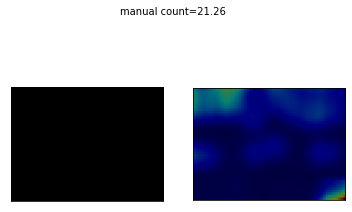

In [68]:
model.eval()
with torch.no_grad():
    output = model(image, is_normalize=not args["save_output"])
    output_save = output
    output = Normalizer.gpu_normalizer(output, image.size()[2], image.size()[3], INPUT_SIZE,OUTPUT_STRIDE)       
    #postprocessing
    output = np.clip(output, 0, None)
    print(output)
    pdcount = output.sum()
    print(pdcount)
    cmap = plt.cm.get_cmap('jet')
    output_save = np.clip(output_save.squeeze().cpu().numpy(), 0, None)
    output_save = recover_countmap(output_save, image, INPUT_SIZE, OUTPUT_STRIDE)
    output_save = output_save / (output_save.max() + 1e-12)
    output_save = cmap(output_save) * 255.
    # image composition
    nh, nw = output_save.shape[:2]
    output_save = 0.5 * test_img + 0.5 * output_save[:, :, 0:3]

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(dotimage.astype(np.uint8))
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(output_save.astype(np.uint8))
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    fig.suptitle('manual count=%4.2f' % (pdcount), fontsize=10)
    #lt.tight_layout(rect=[0, 0, 1, 1.4])  # maize tassels counting
    plt.show()
    #plt.savefig(os.path.join(epoch_result_dir, image_name.replace('.jpg', '.png')), bbox_inches='tight',dpi=300)

In [100]:
pdcount

21.263014

In [84]:
with torch.no_grad():
        for i, sample in enumerate(val_loader):
            image123, gtcount = sample['image'], sample['gtcount']
            print(image123.size())

2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
8 8
torch.Size([1, 3, 288, 432])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
8 8
torch.Size([1, 3, 288, 432])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 1]
torch.Size([1, 3, 344, 456])
2 8
[0, 0, 1, 

In [83]:
image123.size()

torch.Size([1, 3, 344, 456])

## Training the Model

In [30]:
print('alchemy start...')
#if evaluate_only:
#validate(net, valset, val_loader, criterion, start_epoch, args)
    #return

best_mae = 1000000.0
resume_epoch = -1 if start_epoch == 0 else start_epoch
scheduler = MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1, last_epoch=resume_epoch)
for epoch in range(start_epoch, NUM_EPOCHS):
    # train
    train(net, train_loader, criterion, optimizer, epoch + 1, args)
    if epoch % VAL_EVERY == VAL_EVERY - 1:
        # val
        validate(net, valset, val_loader, criterion, epoch + 1, args)
        # save_checkpoint
        state = {
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch + 1,
            'train_loss': net.train_loss,
            'val_loss': net.val_loss,
            'measure': net.measure
        }
        save_checkpoint(state, SNAPSHOT_DIR, filename='model_ckpt.pth.tar')
        if net.measure['mae'][-1] <= best_mae:
            save_checkpoint(state, SNAPSHOT_DIR, filename='model_best.pth.tar')
            save_checkpoint(state, SNAPSHOT_DIR, filename='model.pth')
            best_mae = net.measure['mae'][-1]
            best_mse = net.measure['mse'][-1]
            best_rmae = net.measure['rmae'][-1]
            best_rmse = net.measure['rmse'][-1]
            best_r2 = net.measure['r2'][-1]
        print(EXP + ' epoch {} finished!'.format(epoch + 1))
        print('best mae: {0:.2f}, best mse: {1:.2f}, best_rmae: {2:.2f}, best_rmse: {3:.2f}, best_r2: {4:.4f}'
              .format(best_mae, best_mse, best_rmae, best_rmse, best_r2))
        plot_learning_curves(net, SNAPSHOT_DIR)
    scheduler.step()

print('Experiments with ' + EXP + ' done!')
with open(os.path.join(SNAPSHOT_DIR, EXP + '.txt'), 'a') as f:
    print(
        'best mae: {0:.2f}, best mse: {1:.2f}, best_rmae: {2:.2f}, best_rmse: {3:.2f}, best_r2: {4:.4f}'
            .format(best_mae, best_mse, best_rmae, best_rmse, best_r2),
        file=f
    )
    print(
        'overall best mae: {0:.2f}, overall best mse: {1:.2f}, overall best_rmae: {2:.2f}, overall best_rmse: {3:.2f}, overall best_r2: {4:.4f}'
            .format(min(net.measure['mae']), min(net.measure['mse']), min(net.measure['rmae']),
                    min(net.measure['rmse']), max(net.measure['r2'])),
        file=f
    )

alchemy start...
57.0
8 8
16.0
8 8
23.0
8 8
49.0
8 8
18.0
8 8
32.0
8 8
65.00001
8 8
14.000002
8 8
67.0
8 8
epoch: 4, train: 1/20, loss: 0.43846, frame: 10.83Hz/10.83Hz
42.000008
8 8
1.0000001
8 8
9.0
8 8
51.000004
8 8
65.99999
8 8
104.00001
8 8
37.000004
8 8
64.00001
8 8
0.0
8 8
epoch: 4, train: 2/20, loss: 0.47485, frame: 17.45Hz/14.14Hz
18.000002
8 8
44.0
8 8
2.0
8 8
85.00001
8 8
17.000002
8 8
38.0
8 8
56.000004
8 8
62.999996
8 8
63.999992
8 8
epoch: 4, train: 3/20, loss: 0.47558, frame: 17.02Hz/15.10Hz
39.999992
8 8
120.0
8 8
69.0
8 8
27.999998
8 8
54.0
8 8
36.000004
8 8
15.999999
8 8
51.0
8 8
19.0
8 8
epoch: 4, train: 4/20, loss: 0.47239, frame: 17.94Hz/15.81Hz
0.0
8 8
68.00001
8 8
38.0
8 8
62.999996
8 8
18.0
8 8
65.99999
8 8
60.0
8 8
70.0
8 8
0.0
8 8
epoch: 4, train: 5/20, loss: 0.45970, frame: 17.25Hz/16.10Hz
62.0
8 8
69.0
8 8
0.0
8 8
30.999998
8 8
41.999996
8 8
1.0
8 8
50.999996
8 8
5.0
8 8
2.9999998
8 8
epoch: 4, train: 6/20, loss: 0.46730, frame: 17.90Hz/16.40Hz
66.0
8 8
54.0


9.0
2 8
[0, 0, 1, 1]
epoch: 4, test: 34/186, pre: 11.08, gt:9.00, me:2.08, mae: 15.05, mse: 21.23, rmae: 33.36%, rmse: 45.44%, frame: 0.99Hz/0.99Hz
30.999998
2 8
[0, 0, 1, 1]
epoch: 4, test: 35/186, pre: 44.67, gt:31.00, me:13.67, mae: 15.01, mse: 21.05, rmae: 33.69%, rmse: 45.40%, frame: 1.05Hz/0.99Hz
5.0
2 8
[0, 0, 1, 1]
epoch: 4, test: 36/186, pre: 15.65, gt:5.00, me:10.65, mae: 14.89, mse: 20.83, rmae: 38.96%, rmse: 57.76%, frame: 0.87Hz/0.99Hz
39.0
2 8
[0, 0, 1, 1]
epoch: 4, test: 37/186, pre: 23.18, gt:39.00, me:-15.82, mae: 14.91, mse: 20.71, rmae: 39.01%, rmse: 57.34%, frame: 0.99Hz/0.99Hz
94.00001
2 8
[0, 0, 1, 1]
epoch: 4, test: 38/186, pre: 31.00, gt:94.00, me:-63.00, mae: 16.18, mse: 22.85, rmae: 39.79%, rmse: 57.63%, frame: 0.91Hz/0.98Hz
37.0
2 8
[0, 0, 1, 1]
epoch: 4, test: 39/186, pre: 35.24, gt:37.00, me:-1.76, mae: 15.81, mse: 22.56, rmae: 38.84%, rmse: 56.85%, frame: 1.02Hz/0.99Hz
68.00001
2 8
[0, 0, 1, 1]
epoch: 4, test: 40/186, pre: 30.49, gt:68.00, me:-37.51, mae: 

116.99999
2 8
[0, 0, 1, 1]
epoch: 4, test: 88/186, pre: 42.99, gt:117.00, me:-74.01, mae: 16.08, mse: 22.77, rmae: 45.98%, rmse: 115.20%, frame: 1.00Hz/1.01Hz
0.0
2 8
[0, 0, 1, 1]
epoch: 4, test: 89/186, pre: 3.81, gt:0.00, me:3.81, mae: 15.94, mse: 22.64, rmae: 45.98%, rmse: 115.20%, frame: 1.00Hz/1.01Hz
0.0
2 8
[0, 0, 1, 1]
epoch: 4, test: 90/186, pre: 1.07, gt:0.00, me:1.07, mae: 15.78, mse: 22.52, rmae: 45.98%, rmse: 115.20%, frame: 0.98Hz/1.01Hz
62.999996
2 8
[0, 0, 1, 1]
epoch: 4, test: 91/186, pre: 42.45, gt:63.00, me:-20.55, mae: 15.83, mse: 22.50, rmae: 45.81%, rmse: 114.55%, frame: 1.04Hz/1.01Hz
2.0
2 8
[0, 0, 1, 1]
epoch: 4, test: 92/186, pre: 0.68, gt:2.00, me:-1.32, mae: 15.67, mse: 22.37, rmae: 46.06%, rmse: 114.09%, frame: 0.97Hz/1.01Hz
1.9999998
8 8
epoch: 4, test: 93/186, pre: 0.91, gt:2.00, me:-1.09, mae: 15.52, mse: 22.25, rmae: 46.16%, rmse: 113.56%, frame: 1.17Hz/1.01Hz
62.000004
2 8
[0, 0, 1, 1]
epoch: 4, test: 94/186, pre: 33.78, gt:62.00, me:-28.22, mae: 15.65, 

epoch: 4, test: 141/186, pre: 46.51, gt:51.00, me:-4.49, mae: 14.31, mse: 20.57, rmae: 60.83%, rmse: 167.02%, frame: 1.05Hz/1.01Hz
96.0
2 8
[0, 0, 1, 1]
epoch: 4, test: 142/186, pre: 45.78, gt:96.00, me:-50.22, mae: 14.56, mse: 20.92, rmae: 60.76%, rmse: 166.45%, frame: 0.98Hz/1.01Hz
17.999998
2 8
[0, 0, 1, 1]
epoch: 4, test: 143/186, pre: 22.61, gt:18.00, me:4.61, mae: 14.49, mse: 20.85, rmae: 60.50%, rmse: 165.83%, frame: 0.95Hz/1.01Hz
99.99999
2 8
[0, 0, 1, 1]
epoch: 4, test: 144/186, pre: 44.26, gt:100.00, me:-55.74, mae: 14.78, mse: 21.29, rmae: 60.46%, rmse: 165.28%, frame: 0.99Hz/1.01Hz
63.999996
2 8
[0, 0, 1, 1]
epoch: 4, test: 145/186, pre: 39.65, gt:64.00, me:-24.35, mae: 14.84, mse: 21.32, rmae: 60.30%, rmse: 164.70%, frame: 1.01Hz/1.01Hz
48.0
2 8
[0, 0, 1, 1]
epoch: 4, test: 146/186, pre: 40.04, gt:48.00, me:-7.96, mae: 14.80, mse: 21.25, rmae: 59.98%, rmse: 164.10%, frame: 1.01Hz/1.01Hz
5.0000005
2 8
[0, 0, 1, 1]
epoch: 4, test: 147/186, pre: 14.97, gt:5.00, me:9.97, mae: 

epoch: 5, train: 11/20, loss: 0.52656, frame: 17.35Hz/17.20Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 5, train: 12/20, loss: 0.53779, frame: 17.38Hz/17.22Hz
70.0
8 8
8 8
8 8
8 8
8 8
8 8
30.999996
8 8
8 8
8 8
epoch: 5, train: 13/20, loss: 0.54701, frame: 17.52Hz/17.24Hz
8 8
8 8
8 8
39.0
8 8
8 8
8 8
33.999996
8 8
8 8
8 8
epoch: 5, train: 14/20, loss: 0.54335, frame: 17.42Hz/17.25Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 5, train: 15/20, loss: 0.55379, frame: 17.19Hz/17.25Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 5, train: 16/20, loss: 0.56896, frame: 15.97Hz/17.17Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 5, train: 17/20, loss: 0.57407, frame: 16.96Hz/17.16Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 5, train: 18/20, loss: 0.58100, frame: 17.09Hz/17.15Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 5, train: 19/20, loss: 0.57298, frame: 16.55Hz/17.12Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 5, train: 20/20, loss: 0.57194, frame: 17.49Hz/17.14Hz
2 8
[0, 0, 1, 1]
epoch: 5,

epoch: 5, test: 51/186, pre: 12.44, gt:0.00, me:12.44, mae: 19.28, mse: 24.91, rmae: 78.20%, rmse: 190.71%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 52/186, pre: 61.00, gt:62.00, me:-1.00, mae: 18.93, mse: 24.67, rmae: 76.57%, rmse: 188.67%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 53/186, pre: 4.06, gt:0.00, me:4.06, mae: 18.65, mse: 24.44, rmae: 76.57%, rmse: 188.67%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 54/186, pre: 52.84, gt:66.00, me:-13.16, mae: 18.55, mse: 24.28, rmae: 75.39%, rmse: 186.72%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 55/186, pre: 42.55, gt:40.00, me:2.55, mae: 18.26, mse: 24.06, rmae: 73.98%, rmse: 184.80%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 56/186, pre: 63.48, gt:56.00, me:7.48, mae: 18.06, mse: 23.86, rmae: 72.77%, rmse: 182.96%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 57/186, pre: 67.04, gt:53.00, me:14.04, mae: 17.99, mse: 23.73, rmae: 71.86%, rmse: 181.19%, frame: 1.03Hz/

epoch: 5, test: 108/186, pre: 38.36, gt:68.00, me:-29.64, mae: 16.45, mse: 21.90, rmae: 59.06%, rmse: 138.47%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 109/186, pre: 25.41, gt:19.00, me:6.41, mae: 16.36, mse: 21.81, rmae: 58.80%, rmse: 137.82%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 110/186, pre: 10.36, gt:9.00, me:1.36, mae: 16.22, mse: 21.71, rmae: 58.37%, rmse: 137.14%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 111/186, pre: 60.14, gt:42.00, me:18.14, mae: 16.24, mse: 21.68, rmae: 58.22%, rmse: 136.54%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 112/186, pre: 64.27, gt:62.00, me:2.27, mae: 16.12, mse: 21.58, rmae: 57.69%, rmse: 135.87%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 113/186, pre: 3.66, gt:0.00, me:3.66, mae: 16.01, mse: 21.49, rmae: 57.69%, rmse: 135.87%, frame: 1.00Hz/1.02Hz
8 8
epoch: 5, test: 114/186, pre: 10.51, gt:2.00, me:8.51, mae: 15.94, mse: 21.41, rmae: 61.23%, rmse: 141.50%, frame: 1.16Hz/1.02Hz
2 

epoch: 5, test: 164/186, pre: 5.49, gt:0.00, me:5.49, mae: 15.64, mse: 20.85, rmae: 64.70%, rmse: 143.39%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 165/186, pre: 76.11, gt:63.00, me:13.11, mae: 15.63, mse: 20.81, rmae: 64.41%, rmse: 142.93%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 166/186, pre: 29.57, gt:38.00, me:-8.43, mae: 15.58, mse: 20.75, rmae: 64.14%, rmse: 142.48%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 167/186, pre: 31.76, gt:16.00, me:15.76, mae: 15.59, mse: 20.73, rmae: 64.36%, rmse: 142.24%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 168/186, pre: 5.13, gt:1.00, me:4.13, mae: 15.52, mse: 20.67, rmae: 66.60%, rmse: 145.60%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 169/186, pre: 27.27, gt:16.00, me:11.27, mae: 15.49, mse: 20.63, rmae: 66.62%, rmse: 145.24%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 5, test: 170/186, pre: 37.48, gt:22.00, me:15.48, mae: 15.49, mse: 20.60, rmae: 66.65%, rmse: 144.89%, frame: 1

epoch: 6, test: 20/186, pre: 24.01, gt:51.00, me:-26.99, mae: 21.78, mse: 24.98, rmae: 43.10%, rmse: 46.64%, frame: 0.98Hz/0.99Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 21/186, pre: 26.48, gt:51.00, me:-24.52, mae: 21.91, mse: 24.96, rmae: 43.33%, rmse: 46.71%, frame: 1.00Hz/0.99Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 22/186, pre: 15.89, gt:31.00, me:-15.11, mae: 21.60, mse: 24.60, rmae: 43.58%, rmse: 46.80%, frame: 0.92Hz/0.99Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 23/186, pre: 62.92, gt:102.00, me:-39.08, mae: 22.36, mse: 25.40, rmae: 43.35%, rmse: 46.46%, frame: 0.98Hz/0.99Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 24/186, pre: 4.52, gt:0.00, me:4.52, mae: 21.61, mse: 24.88, rmae: 43.35%, rmse: 46.46%, frame: 0.88Hz/0.98Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 25/186, pre: 10.65, gt:18.00, me:-7.35, mae: 21.04, mse: 24.42, rmae: 43.25%, rmse: 46.24%, frame: 0.92Hz/0.98Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 26/186, pre: 28.90, gt:36.00, me:-7.10, mae: 20.51, mse: 23.99, rmae: 42.30%, rmse: 45.48%, frame: 0.95Hz/

epoch: 6, test: 77/186, pre: 5.75, gt:14.00, me:-8.25, mae: 19.28, mse: 23.32, rmae: 52.11%, rmse: 75.45%, frame: 1.01Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 78/186, pre: 12.81, gt:13.00, me:-0.19, mae: 19.03, mse: 23.17, rmae: 51.40%, rmse: 74.91%, frame: 0.99Hz/0.99Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 79/186, pre: 64.36, gt:96.00, me:-31.64, mae: 19.19, mse: 23.30, rmae: 51.14%, rmse: 74.49%, frame: 0.98Hz/0.99Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 80/186, pre: 9.09, gt:9.00, me:0.09, mae: 18.95, mse: 23.15, rmae: 50.45%, rmse: 73.98%, frame: 0.99Hz/0.99Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 81/186, pre: 15.78, gt:34.00, me:-18.22, mae: 18.94, mse: 23.10, rmae: 50.50%, rmse: 73.74%, frame: 1.03Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 82/186, pre: 21.47, gt:68.00, me:-46.53, mae: 19.28, mse: 23.52, rmae: 50.74%, rmse: 73.68%, frame: 0.88Hz/0.99Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 83/186, pre: 30.36, gt:45.00, me:-14.64, mae: 19.22, mse: 23.44, rmae: 50.50%, rmse: 73.28%, frame: 0.98Hz/0.

epoch: 6, test: 134/186, pre: 5.07, gt:1.00, me:4.07, mae: 17.89, mse: 22.63, rmae: 55.32%, rmse: 88.50%, frame: 0.99Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 135/186, pre: 42.64, gt:45.00, me:-2.36, mae: 17.78, mse: 22.55, rmae: 54.92%, rmse: 88.14%, frame: 0.99Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 136/186, pre: 13.58, gt:18.00, me:-4.42, mae: 17.68, mse: 22.47, rmae: 54.68%, rmse: 87.82%, frame: 1.00Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 137/186, pre: 49.65, gt:85.00, me:-35.35, mae: 17.81, mse: 22.59, rmae: 54.57%, rmse: 87.55%, frame: 1.00Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 138/186, pre: 12.60, gt:18.00, me:-5.40, mae: 17.72, mse: 22.51, rmae: 54.38%, rmse: 87.25%, frame: 1.00Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 139/186, pre: 19.77, gt:44.00, me:-24.23, mae: 17.76, mse: 22.53, rmae: 54.39%, rmse: 87.05%, frame: 1.04Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 6, test: 140/186, pre: 42.19, gt:62.00, me:-19.81, mae: 17.78, mse: 22.51, rmae: 54.21%, rmse: 86.76%, frame: 1.

epoch: 7, train: 4/20, loss: 0.51085, frame: 17.32Hz/17.20Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 5/20, loss: 0.49005, frame: 15.63Hz/16.89Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 6/20, loss: 0.51660, frame: 17.35Hz/16.97Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 7/20, loss: 0.49678, frame: 17.55Hz/17.05Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 8/20, loss: 0.47322, frame: 17.09Hz/17.06Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 9/20, loss: 0.45882, frame: 17.32Hz/17.08Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 10/20, loss: 0.44856, frame: 17.12Hz/17.09Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 11/20, loss: 0.44560, frame: 17.09Hz/17.09Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 12/20, loss: 0.45020, frame: 17.15Hz/17.09Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 13/20, loss: 0.43645, frame: 17.06Hz/17.09Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 7, train: 14/20, lo

epoch: 7, test: 47/186, pre: 55.90, gt:63.00, me:-7.10, mae: 15.06, mse: 21.01, rmae: 41.62%, rmse: 69.10%, frame: 1.08Hz/1.02Hz
8 8
epoch: 7, test: 48/186, pre: 37.91, gt:4.00, me:33.91, mae: 15.46, mse: 21.36, rmae: 59.94%, rmse: 144.90%, frame: 1.25Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 49/186, pre: 54.04, gt:51.00, me:3.04, mae: 15.20, mse: 21.14, rmae: 58.74%, rmse: 143.28%, frame: 1.04Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 50/186, pre: 44.24, gt:37.00, me:7.24, mae: 15.04, mse: 20.95, rmae: 57.89%, rmse: 141.74%, frame: 1.03Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 51/186, pre: 6.14, gt:0.00, me:6.14, mae: 14.87, mse: 20.77, rmae: 57.89%, rmse: 141.74%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 52/186, pre: 47.80, gt:62.00, me:-14.20, mae: 14.86, mse: 20.66, rmae: 57.14%, rmse: 140.27%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 53/186, pre: 2.49, gt:0.00, me:2.49, mae: 14.62, mse: 20.47, rmae: 57.14%, rmse: 140.27%, frame: 1.01Hz/1.03Hz
2 8
[0, 0,

epoch: 7, test: 104/186, pre: 19.94, gt:44.00, me:-24.06, mae: 13.73, mse: 19.89, rmae: 46.52%, rmse: 106.57%, frame: 0.93Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 105/186, pre: 46.58, gt:54.00, me:-7.42, mae: 13.67, mse: 19.81, rmae: 46.18%, rmse: 106.03%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 106/186, pre: 20.34, gt:19.00, me:1.34, mae: 13.56, mse: 19.72, rmae: 45.77%, rmse: 105.48%, frame: 0.97Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 107/186, pre: 27.31, gt:17.00, me:10.31, mae: 13.53, mse: 19.65, rmae: 45.92%, rmse: 105.12%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 108/186, pre: 39.05, gt:68.00, me:-28.95, mae: 13.67, mse: 19.76, rmae: 45.89%, rmse: 104.67%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 109/186, pre: 20.58, gt:19.00, me:1.58, mae: 13.56, mse: 19.67, rmae: 45.51%, rmse: 104.15%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 110/186, pre: 15.29, gt:9.00, me:6.29, mae: 13.49, mse: 19.59, rmae: 45.76%, rmse: 103.87%, fram

epoch: 7, test: 160/186, pre: 50.50, gt:70.00, me:-19.50, mae: 12.80, mse: 19.11, rmae: 56.49%, rmse: 139.07%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 161/186, pre: 51.91, gt:61.00, me:-9.09, mae: 12.78, mse: 19.07, rmae: 56.22%, rmse: 138.61%, frame: 1.00Hz/1.02Hz
8 8
epoch: 7, test: 162/186, pre: 24.55, gt:24.00, me:0.55, mae: 12.70, mse: 19.01, rmae: 55.86%, rmse: 138.15%, frame: 1.21Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 163/186, pre: 58.91, gt:66.00, me:-7.09, mae: 12.67, mse: 18.96, rmae: 55.56%, rmse: 137.69%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 164/186, pre: 5.41, gt:0.00, me:5.41, mae: 12.62, mse: 18.90, rmae: 55.56%, rmse: 137.69%, frame: 0.91Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 165/186, pre: 58.44, gt:63.00, me:-4.56, mae: 12.58, mse: 18.85, rmae: 55.25%, rmse: 137.24%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 7, test: 166/186, pre: 31.24, gt:38.00, me:-6.76, mae: 12.54, mse: 18.80, rmae: 55.00%, rmse: 136.81%, frame: 0.99Hz/1.02

epoch: 8, test: 16/186, pre: 25.59, gt:36.00, me:-10.41, mae: 16.81, mse: 21.05, rmae: 32.58%, rmse: 38.30%, frame: 1.06Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 17/186, pre: 43.85, gt:42.00, me:1.85, mae: 15.93, mse: 20.43, rmae: 30.92%, rmse: 37.17%, frame: 1.06Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 18/186, pre: 45.46, gt:50.00, me:-4.54, mae: 15.30, mse: 19.88, rmae: 29.71%, rmse: 36.19%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 19/186, pre: 58.65, gt:66.00, me:-7.35, mae: 14.88, mse: 19.43, rmae: 28.73%, rmse: 35.32%, frame: 1.04Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 20/186, pre: 40.48, gt:51.00, me:-10.52, mae: 14.66, mse: 19.08, rmae: 28.33%, rmse: 34.73%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 21/186, pre: 39.05, gt:51.00, me:-11.95, mae: 14.54, mse: 18.80, rmae: 28.09%, rmse: 34.28%, frame: 0.96Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 22/186, pre: 27.34, gt:31.00, me:-3.66, mae: 14.04, mse: 18.39, rmae: 27.35%, rmse: 33.58%, frame: 1.04Hz/

epoch: 8, test: 73/186, pre: 45.20, gt:64.00, me:-18.80, mae: 14.03, mse: 18.12, rmae: 42.86%, rmse: 81.23%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 74/186, pre: 22.61, gt:36.00, me:-13.39, mae: 14.02, mse: 18.06, rmae: 42.78%, rmse: 80.75%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 75/186, pre: 27.44, gt:35.00, me:-7.56, mae: 13.93, mse: 17.96, rmae: 42.46%, rmse: 80.20%, frame: 1.05Hz/1.02Hz
8 8
epoch: 8, test: 76/186, pre: 19.54, gt:18.00, me:1.54, mae: 13.77, mse: 17.85, rmae: 41.97%, rmse: 79.62%, frame: 1.20Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 77/186, pre: 6.19, gt:14.00, me:-7.81, mae: 13.69, mse: 17.75, rmae: 42.17%, rmse: 79.33%, frame: 0.98Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 78/186, pre: 13.93, gt:13.00, me:0.93, mae: 13.53, mse: 17.64, rmae: 41.68%, rmse: 78.77%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 79/186, pre: 62.71, gt:96.00, me:-33.29, mae: 13.78, mse: 17.92, rmae: 41.58%, rmse: 78.33%, frame: 1.00Hz/1.02Hz
2 8
[0, 

epoch: 8, test: 130/186, pre: 6.20, gt:3.00, me:3.20, mae: 12.18, mse: 16.69, rmae: 42.27%, rmse: 83.40%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 131/186, pre: 25.09, gt:4.00, me:21.09, mae: 12.24, mse: 16.73, rmae: 46.28%, rmse: 95.89%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 132/186, pre: 27.09, gt:70.00, me:-42.91, mae: 12.48, mse: 17.08, rmae: 46.40%, rmse: 95.66%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 133/186, pre: 23.88, gt:38.00, me:-14.12, mae: 12.49, mse: 17.06, rmae: 46.33%, rmse: 95.33%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 134/186, pre: 6.25, gt:1.00, me:5.25, mae: 12.43, mse: 17.00, rmae: 50.19%, rmse: 106.01%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 135/186, pre: 46.62, gt:45.00, me:1.62, mae: 12.35, mse: 16.94, rmae: 49.82%, rmse: 105.58%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 8, test: 136/186, pre: 13.34, gt:18.00, me:-4.66, mae: 12.30, mse: 16.88, rmae: 49.63%, rmse: 105.19%, frame: 0.99H

epoch: 8, test: 186/186, pre: 23.89, gt:0.00, me:23.89, mae: 12.24, mse: 16.87, rmae: 45.72%, rmse: 96.41%, frame: 0.96Hz/1.02Hz
epoch: 8, mae: 12.24, mse: 16.87, rmae: 45.72%, rmse: 96.41%, r2: 0.7853
exp_directory epoch 8 finished!
best mae: 12.24, best mse: 16.87, best_rmae: 45.72, best_rmse: 96.41, best_r2: 0.7853
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 9, train: 1/20, loss: 0.43382, frame: 15.29Hz/15.29Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 9, train: 2/20, loss: 0.52221, frame: 16.37Hz/15.83Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 9, train: 3/20, loss: 0.44000, frame: 17.32Hz/16.33Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 9, train: 4/20, loss: 0.44325, frame: 16.46Hz/16.36Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 9, train: 5/20, loss: 0.41281, frame: 16.90Hz/16.47Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 9, train: 6/20, loss: 0.41509, frame: 17.12Hz/16.58Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 9, train: 7/20, loss: 0.43512, frame: 16.61Hz/16.58Hz
8

epoch: 9, test: 42/186, pre: 28.15, gt:37.00, me:-8.85, mae: 9.87, mse: 12.82, rmae: 30.34%, rmse: 44.42%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 43/186, pre: 17.49, gt:0.00, me:17.49, mae: 10.04, mse: 12.95, rmae: 30.34%, rmse: 44.42%, frame: 0.92Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 44/186, pre: 3.44, gt:0.00, me:3.44, mae: 9.89, mse: 12.81, rmae: 30.34%, rmse: 44.42%, frame: 1.00Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 45/186, pre: 18.35, gt:24.00, me:-5.65, mae: 9.80, mse: 12.70, rmae: 30.17%, rmse: 44.03%, frame: 1.01Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 46/186, pre: 65.50, gt:83.00, me:-17.50, mae: 9.97, mse: 12.82, rmae: 29.96%, rmse: 43.63%, frame: 1.00Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 47/186, pre: 52.24, gt:63.00, me:-10.76, mae: 9.98, mse: 12.78, rmae: 29.66%, rmse: 43.20%, frame: 1.09Hz/1.02Hz
8 8
epoch: 9, test: 48/186, pre: 27.18, gt:4.00, me:23.18, mae: 10.26, mse: 13.08, rmae: 42.15%, rmse: 97.25%, frame: 1.25Hz/1.02Hz
2 8
[0, 0, 1, 1]

epoch: 9, test: 100/186, pre: 41.70, gt:71.00, me:-29.30, mae: 9.16, mse: 12.46, rmae: 32.26%, rmse: 71.11%, frame: 1.03Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 101/186, pre: 58.10, gt:67.00, me:-8.90, mae: 9.16, mse: 12.43, rmae: 32.06%, rmse: 70.74%, frame: 1.05Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 102/186, pre: 22.08, gt:17.00, me:5.08, mae: 9.12, mse: 12.38, rmae: 32.03%, rmse: 70.43%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 103/186, pre: 12.45, gt:13.00, me:-0.55, mae: 9.04, mse: 12.32, rmae: 31.74%, rmse: 70.05%, frame: 0.94Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 104/186, pre: 23.98, gt:44.00, me:-20.02, mae: 9.14, mse: 12.42, rmae: 31.88%, rmse: 69.84%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 105/186, pre: 56.81, gt:54.00, me:2.81, mae: 9.08, mse: 12.36, rmae: 31.61%, rmse: 69.47%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 106/186, pre: 23.73, gt:19.00, me:4.73, mae: 9.04, mse: 12.31, rmae: 31.54%, rmse: 69.16%, frame: 0.98Hz/1.0

epoch: 9, test: 157/186, pre: 13.05, gt:5.00, me:8.05, mae: 8.02, mse: 11.16, rmae: 34.48%, rmse: 79.37%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 158/186, pre: 62.58, gt:64.00, me:-1.42, mae: 7.98, mse: 11.13, rmae: 34.26%, rmse: 79.10%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 159/186, pre: 79.25, gt:120.00, me:-40.75, mae: 8.19, mse: 11.55, rmae: 34.26%, rmse: 78.88%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 160/186, pre: 52.91, gt:70.00, me:-17.09, mae: 8.24, mse: 11.60, rmae: 34.19%, rmse: 78.64%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 161/186, pre: 60.49, gt:61.00, me:-0.51, mae: 8.19, mse: 11.56, rmae: 33.97%, rmse: 78.38%, frame: 1.03Hz/1.02Hz
8 8
epoch: 9, test: 162/186, pre: 15.78, gt:24.00, me:-8.22, mae: 8.19, mse: 11.54, rmae: 33.97%, rmse: 78.17%, frame: 1.21Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 9, test: 163/186, pre: 65.98, gt:66.00, me:-0.02, mae: 8.14, mse: 11.51, rmae: 33.75%, rmse: 77.91%, frame: 0.97Hz/1.02Hz
2 8
[0,

epoch: 10, test: 13/186, pre: 20.74, gt:63.00, me:-42.26, mae: 35.25, mse: 39.12, rmae: 67.57%, rmse: 69.01%, frame: 1.06Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 14/186, pre: 11.25, gt:24.00, me:-12.75, mae: 33.64, mse: 37.85, rmae: 66.54%, rmse: 68.00%, frame: 1.01Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 15/186, pre: 10.42, gt:40.00, me:-29.58, mae: 33.37, mse: 37.35, rmae: 67.03%, rmse: 68.41%, frame: 1.01Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 16/186, pre: 19.09, gt:36.00, me:-16.91, mae: 32.34, mse: 36.41, rmae: 65.78%, rmse: 67.27%, frame: 1.04Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 17/186, pre: 29.03, gt:42.00, me:-12.97, mae: 31.20, mse: 35.47, rmae: 63.72%, rmse: 65.69%, frame: 1.04Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 18/186, pre: 28.61, gt:50.00, me:-21.39, mae: 30.66, mse: 34.83, rmae: 62.56%, rmse: 64.63%, frame: 1.01Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 19/186, pre: 46.99, gt:66.00, me:-19.01, mae: 30.05, mse: 34.18, rmae: 60.78%, rmse: 63.26%, fr

epoch: 10, test: 69/186, pre: 9.24, gt:26.00, me:-16.76, mae: 25.96, mse: 32.24, rmae: 67.15%, rmse: 80.84%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 70/186, pre: 26.61, gt:63.00, me:-36.39, mae: 26.11, mse: 32.30, rmae: 67.00%, rmse: 80.53%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 71/186, pre: 29.04, gt:104.00, me:-74.96, mae: 26.80, mse: 33.29, rmae: 67.08%, rmse: 80.40%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 72/186, pre: 10.49, gt:18.00, me:-7.51, mae: 26.53, mse: 33.07, rmae: 66.69%, rmse: 79.95%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 73/186, pre: 13.77, gt:64.00, me:-50.23, mae: 26.86, mse: 33.36, rmae: 66.86%, rmse: 79.93%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 74/186, pre: 18.13, gt:36.00, me:-17.87, mae: 26.73, mse: 33.20, rmae: 66.61%, rmse: 79.56%, frame: 1.05Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 75/186, pre: 14.55, gt:35.00, me:-20.45, mae: 26.65, mse: 33.06, rmae: 66.49%, rmse: 79.29%, fra

epoch: 10, test: 125/186, pre: 29.46, gt:47.00, me:-17.54, mae: 24.93, mse: 31.56, rmae: 62.41%, rmse: 73.29%, frame: 0.96Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 126/186, pre: 6.32, gt:21.00, me:-14.68, mae: 24.85, mse: 31.46, rmae: 62.47%, rmse: 73.26%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 127/186, pre: 10.19, gt:15.00, me:-4.81, mae: 24.69, mse: 31.34, rmae: 62.21%, rmse: 73.01%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 128/186, pre: 22.22, gt:40.00, me:-17.78, mae: 24.64, mse: 31.26, rmae: 62.06%, rmse: 72.81%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 129/186, pre: 41.75, gt:64.00, me:-22.25, mae: 24.62, mse: 31.20, rmae: 61.83%, rmse: 72.57%, frame: 1.07Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 130/186, pre: 2.97, gt:3.00, me:-0.03, mae: 24.43, mse: 31.08, rmae: 61.33%, rmse: 72.27%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 131/186, pre: 4.28, gt:4.00, me:0.28, mae: 24.25, mse: 30.96, rmae: 60.88%, rmse: 71.97%, fram

epoch: 10, test: 181/186, pre: 2.88, gt:4.00, me:-1.12, mae: 24.22, mse: 31.13, rmae: 59.73%, rmse: 69.73%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 182/186, pre: 8.39, gt:12.00, me:-3.61, mae: 24.10, mse: 31.04, rmae: 59.55%, rmse: 69.56%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 183/186, pre: 28.44, gt:50.00, me:-21.56, mae: 24.09, mse: 31.00, rmae: 59.46%, rmse: 69.44%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 184/186, pre: 15.53, gt:33.00, me:-17.47, mae: 24.05, mse: 30.94, rmae: 59.42%, rmse: 69.35%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 185/186, pre: 22.22, gt:90.00, me:-67.78, mae: 24.29, mse: 31.26, rmae: 59.51%, rmse: 69.39%, frame: 0.91Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 10, test: 186/186, pre: 2.75, gt:0.00, me:2.75, mae: 24.17, mse: 31.17, rmae: 59.51%, rmse: 69.39%, frame: 1.02Hz/1.02Hz
epoch: 10, mae: 24.17, mse: 31.17, rmae: 59.51%, rmse: 69.39%, r2: 0.4975
exp_directory epoch 10 finished!
best mae: 8.04, best mse:

epoch: 11, test: 37/186, pre: 25.27, gt:39.00, me:-13.73, mae: 13.15, mse: 16.70, rmae: 41.90%, rmse: 60.48%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 38/186, pre: 41.99, gt:94.00, me:-52.01, mae: 14.17, mse: 18.51, rmae: 42.28%, rmse: 60.34%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 39/186, pre: 50.39, gt:37.00, me:13.39, mae: 14.15, mse: 18.40, rmae: 42.11%, rmse: 59.81%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 40/186, pre: 39.50, gt:68.00, me:-28.50, mae: 14.51, mse: 18.72, rmae: 42.11%, rmse: 59.41%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 41/186, pre: 21.63, gt:26.00, me:-4.37, mae: 14.26, mse: 18.50, rmae: 41.46%, rmse: 58.71%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 42/186, pre: 30.53, gt:37.00, me:-6.47, mae: 14.08, mse: 18.31, rmae: 40.86%, rmse: 58.04%, frame: 0.91Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 43/186, pre: 14.52, gt:0.00, me:14.52, mae: 14.09, mse: 18.23, rmae: 40.86%, rmse: 58.04%, frame: 

epoch: 11, test: 94/186, pre: 49.37, gt:62.00, me:-12.63, mae: 12.69, mse: 16.92, rmae: 49.65%, rmse: 145.65%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 95/186, pre: 15.01, gt:26.00, me:-10.99, mae: 12.68, mse: 16.87, rmae: 49.56%, rmse: 144.87%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 96/186, pre: 67.30, gt:42.00, me:25.30, mae: 12.81, mse: 16.97, rmae: 49.69%, rmse: 144.18%, frame: 1.02Hz/1.02Hz
8 8
epoch: 11, test: 97/186, pre: 41.52, gt:59.00, me:-17.48, mae: 12.86, mse: 16.98, rmae: 49.46%, rmse: 143.39%, frame: 1.24Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 98/186, pre: 85.45, gt:62.00, me:23.45, mae: 12.96, mse: 17.06, rmae: 49.33%, rmse: 142.64%, frame: 1.07Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 99/186, pre: 53.21, gt:66.00, me:-12.79, mae: 12.96, mse: 17.02, rmae: 48.99%, rmse: 141.86%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 100/186, pre: 48.32, gt:71.00, me:-22.68, mae: 13.06, mse: 17.09, rmae: 48.81%, rmse: 141.12%, frame: 1.

epoch: 11, test: 150/186, pre: 80.53, gt:52.00, me:28.53, mae: 13.35, mse: 17.52, rmae: 48.16%, rmse: 123.97%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 151/186, pre: 55.63, gt:57.00, me:-1.37, mae: 13.27, mse: 17.46, rmae: 47.84%, rmse: 123.53%, frame: 1.01Hz/1.02Hz
8 8
epoch: 11, test: 152/186, pre: 0.33, gt:0.00, me:0.33, mae: 13.19, mse: 17.41, rmae: 47.84%, rmse: 123.53%, frame: 1.15Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 153/186, pre: 51.71, gt:69.00, me:-17.29, mae: 13.21, mse: 17.41, rmae: 47.68%, rmse: 123.11%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 154/186, pre: 60.45, gt:52.00, me:8.45, mae: 13.18, mse: 17.36, rmae: 47.46%, rmse: 122.69%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 155/186, pre: 23.09, gt:28.00, me:-4.91, mae: 13.13, mse: 17.31, rmae: 47.25%, rmse: 122.27%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 11, test: 156/186, pre: 54.88, gt:40.00, me:14.88, mae: 13.14, mse: 17.30, rmae: 47.18%, rmse: 121.89%, frame: 1.02

epoch: 12, test: 5/186, pre: 26.90, gt:32.00, me:-5.10, mae: 20.39, mse: 25.32, rmae: 38.80%, rmse: 43.54%, frame: 1.02Hz/1.00Hz
8 8
epoch: 12, test: 6/186, pre: 15.56, gt:49.00, me:-33.44, mae: 22.57, mse: 26.84, rmae: 43.71%, rmse: 48.54%, frame: 1.14Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 7/186, pre: 22.45, gt:41.00, me:-18.55, mae: 21.99, mse: 25.82, rmae: 43.93%, rmse: 48.08%, frame: 1.05Hz/1.03Hz
8 8
epoch: 12, test: 8/186, pre: 8.80, gt:60.00, me:-51.20, mae: 25.64, mse: 30.18, rmae: 49.10%, rmse: 54.16%, frame: 1.24Hz/1.06Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 9/186, pre: 19.44, gt:32.00, me:-12.56, mae: 24.19, mse: 28.76, rmae: 48.01%, rmse: 52.71%, frame: 1.02Hz/1.05Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 10/186, pre: 19.29, gt:42.00, me:-22.71, mae: 24.04, mse: 28.22, rmae: 48.62%, rmse: 52.85%, frame: 1.00Hz/1.05Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 11/186, pre: 30.53, gt:66.00, me:-35.47, mae: 25.08, mse: 28.95, rmae: 49.08%, rmse: 52.93%, frame: 1.05Hz/1.05Hz
2 8
[0, 0, 1, 

epoch: 12, test: 61/186, pre: 22.33, gt:51.00, me:-28.67, mae: 21.68, mse: 26.48, rmae: 50.31%, rmse: 53.39%, frame: 1.04Hz/1.02Hz
8 8
epoch: 12, test: 62/186, pre: 4.69, gt:36.00, me:-31.31, mae: 21.83, mse: 26.56, rmae: 50.97%, rmse: 54.18%, frame: 1.21Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 63/186, pre: 0.01, gt:0.00, me:0.01, mae: 21.49, mse: 26.35, rmae: 50.97%, rmse: 54.18%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 64/186, pre: 0.34, gt:1.00, me:-0.66, mae: 21.16, mse: 26.15, rmae: 51.23%, rmse: 54.40%, frame: 0.92Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 65/186, pre: 30.88, gt:69.00, me:-38.12, mae: 21.42, mse: 26.37, rmae: 51.30%, rmse: 54.41%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 66/186, pre: 23.45, gt:65.00, me:-41.55, mae: 21.73, mse: 26.67, rmae: 51.51%, rmse: 54.59%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 67/186, pre: 29.51, gt:64.00, me:-34.49, mae: 21.92, mse: 26.80, rmae: 51.55%, rmse: 54.58%, frame: 1.08Hz/1.02Hz
8 

epoch: 12, test: 117/186, pre: 22.28, gt:52.00, me:-29.72, mae: 21.73, mse: 26.76, rmae: 63.95%, rmse: 128.09%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 118/186, pre: 34.80, gt:47.00, me:-12.20, mae: 21.65, mse: 26.67, rmae: 63.60%, rmse: 127.52%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 119/186, pre: 26.39, gt:51.00, me:-24.61, mae: 21.68, mse: 26.65, rmae: 63.46%, rmse: 127.02%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 120/186, pre: 19.06, gt:41.00, me:-21.94, mae: 21.68, mse: 26.62, rmae: 63.37%, rmse: 126.55%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 121/186, pre: 23.39, gt:45.00, me:-21.61, mae: 21.68, mse: 26.58, rmae: 63.23%, rmse: 126.06%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 122/186, pre: 38.22, gt:61.00, me:-22.78, mae: 21.69, mse: 26.55, rmae: 63.00%, rmse: 125.54%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 123/186, pre: 19.57, gt:1.00, me:18.57, mae: 21.66, mse: 26.50, rmae: 78.88%, rmse:

epoch: 12, test: 173/186, pre: 2.17, gt:0.00, me:2.17, mae: 21.44, mse: 26.39, rmae: 69.65%, rmse: 183.03%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 174/186, pre: 3.56, gt:14.00, me:-10.44, mae: 21.38, mse: 26.33, rmae: 69.68%, rmse: 182.55%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 175/186, pre: 28.30, gt:54.00, me:-25.70, mae: 21.40, mse: 26.33, rmae: 69.54%, rmse: 182.02%, frame: 1.02Hz/1.02Hz
8 8
epoch: 12, test: 176/186, pre: 11.92, gt:64.00, me:-52.08, mae: 21.58, mse: 26.54, rmae: 69.62%, rmse: 181.57%, frame: 1.21Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 177/186, pre: 20.41, gt:41.00, me:-20.59, mae: 21.57, mse: 26.51, rmae: 69.50%, rmse: 181.06%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 178/186, pre: 24.12, gt:46.00, me:-21.88, mae: 21.57, mse: 26.49, rmae: 69.37%, rmse: 180.54%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 12, test: 179/186, pre: 23.65, gt:45.00, me:-21.35, mae: 21.57, mse: 26.46, rmae: 69.23%, rmse: 180.03%, frame:

epoch: 13, test: 29/186, pre: 53.48, gt:66.00, me:-12.52, mae: 9.54, mse: 12.71, rmae: 20.68%, rmse: 26.16%, frame: 1.04Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 30/186, pre: 66.82, gt:83.00, me:-16.18, mae: 9.76, mse: 12.84, rmae: 20.64%, rmse: 25.95%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 31/186, pre: 30.33, gt:14.00, me:16.33, mae: 9.97, mse: 12.97, rmae: 23.95%, rmse: 33.46%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 32/186, pre: 24.72, gt:19.00, me:5.72, mae: 9.84, mse: 12.81, rmae: 24.15%, rmse: 33.35%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 33/186, pre: 23.26, gt:17.00, me:6.26, mae: 9.73, mse: 12.66, rmae: 24.56%, rmse: 33.47%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 34/186, pre: 16.07, gt:9.00, me:7.07, mae: 9.65, mse: 12.53, rmae: 26.25%, rmse: 35.75%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 35/186, pre: 41.77, gt:31.00, me:10.77, mae: 9.68, mse: 12.48, rmae: 26.50%, rmse: 35.72%, frame: 1.06Hz/1.03

epoch: 13, test: 86/186, pre: 48.37, gt:52.00, me:-3.63, mae: 10.15, mse: 12.57, rmae: 37.24%, rmse: 75.14%, frame: 0.94Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 87/186, pre: 52.27, gt:63.00, me:-10.73, mae: 10.16, mse: 12.55, rmae: 36.99%, rmse: 74.70%, frame: 1.08Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 88/186, pre: 74.33, gt:117.00, me:-42.67, mae: 10.53, mse: 13.29, rmae: 36.98%, rmse: 74.34%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 89/186, pre: 6.70, gt:0.00, me:6.70, mae: 10.49, mse: 13.23, rmae: 36.98%, rmse: 74.34%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 90/186, pre: 10.00, gt:0.00, me:10.00, mae: 10.48, mse: 13.20, rmae: 36.98%, rmse: 74.34%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 91/186, pre: 52.22, gt:63.00, me:-10.78, mae: 10.48, mse: 13.17, rmae: 36.74%, rmse: 73.91%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 92/186, pre: 10.97, gt:2.00, me:8.97, mae: 10.47, mse: 13.14, rmae: 41.70%, rmse: 88.44%, frame: 0.98

epoch: 13, test: 142/186, pre: 98.13, gt:96.00, me:2.13, mae: 10.12, mse: 12.99, rmae: 55.42%, rmse: 139.04%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 143/186, pre: 21.08, gt:18.00, me:3.08, mae: 10.07, mse: 12.94, rmae: 55.13%, rmse: 138.53%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 144/186, pre: 104.08, gt:100.00, me:4.08, mae: 10.03, mse: 12.90, rmae: 54.75%, rmse: 138.01%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 145/186, pre: 48.40, gt:64.00, me:-15.60, mae: 10.07, mse: 12.92, rmae: 54.53%, rmse: 137.51%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 146/186, pre: 44.90, gt:48.00, me:-3.10, mae: 10.02, mse: 12.88, rmae: 54.17%, rmse: 137.01%, frame: 0.92Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 147/186, pre: 12.52, gt:5.00, me:7.52, mae: 10.00, mse: 12.85, rmae: 54.88%, rmse: 137.11%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 13, test: 148/186, pre: 52.84, gt:65.00, me:-12.16, mae: 10.02, mse: 12.85, rmae: 54.61%, rmse: 136.6

epoch: 14, train: 15/20, loss: 0.39036, frame: 16.77Hz/16.42Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 14, train: 16/20, loss: 0.39065, frame: 17.15Hz/16.47Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 14, train: 17/20, loss: 0.38463, frame: 17.49Hz/16.53Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 14, train: 18/20, loss: 0.38109, frame: 16.77Hz/16.54Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 14, train: 19/20, loss: 0.37734, frame: 17.35Hz/16.59Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 14, train: 20/20, loss: 0.37406, frame: 15.47Hz/16.53Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 1/186, pre: 99.11, gt:97.00, me:2.11, mae: 2.11, mse: 2.11, rmae: 2.17%, rmse: 2.17%, frame: 0.97Hz/0.97Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 2/186, pre: 37.41, gt:40.00, me:-2.59, mae: 2.35, mse: 2.36, rmae: 4.32%, rmse: 4.82%, frame: 1.01Hz/0.99Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 3/186, pre: 26.80, gt:23.00, me:3.80, mae: 2.83, mse: 2.92, rmae: 8.39%, rmse: 10.32%, frame: 0.93Hz/0.97Hz
2 8
[0, 0, 1, 1]


epoch: 14, test: 55/186, pre: 41.06, gt:40.00, me:1.06, mae: 6.78, mse: 9.42, rmae: 37.19%, rmse: 116.37%, frame: 0.88Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 56/186, pre: 52.82, gt:56.00, me:-3.18, mae: 6.71, mse: 9.35, rmae: 36.56%, rmse: 115.20%, frame: 0.87Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 57/186, pre: 60.11, gt:53.00, me:7.11, mae: 6.72, mse: 9.31, rmae: 36.10%, rmse: 114.08%, frame: 0.97Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 58/186, pre: 65.73, gt:65.00, me:0.73, mae: 6.62, mse: 9.23, rmae: 35.43%, rmse: 112.98%, frame: 0.93Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 59/186, pre: 31.28, gt:21.00, me:10.28, mae: 6.68, mse: 9.25, rmae: 35.69%, rmse: 112.11%, frame: 0.94Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 60/186, pre: 55.89, gt:52.00, me:3.89, mae: 6.63, mse: 9.19, rmae: 35.16%, rmse: 111.07%, frame: 1.01Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 61/186, pre: 46.99, gt:51.00, me:-4.01, mae: 6.59, mse: 9.12, rmae: 34.67%, rmse: 110.06%, frame: 1.06Hz/1.01Hz

epoch: 14, test: 112/186, pre: 69.52, gt:62.00, me:7.52, mae: 6.69, mse: 9.00, rmae: 30.35%, rmse: 84.06%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 113/186, pre: 3.80, gt:0.00, me:3.80, mae: 6.67, mse: 8.97, rmae: 30.35%, rmse: 84.06%, frame: 1.01Hz/1.02Hz
8 8
epoch: 14, test: 114/186, pre: 9.33, gt:2.00, me:7.33, mae: 6.67, mse: 8.95, rmae: 33.58%, rmse: 91.05%, frame: 1.16Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 115/186, pre: 64.38, gt:56.00, me:8.38, mae: 6.69, mse: 8.95, rmae: 33.41%, rmse: 90.63%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 116/186, pre: 19.73, gt:15.00, me:4.73, mae: 6.67, mse: 8.92, rmae: 33.39%, rmse: 90.25%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 117/186, pre: 53.57, gt:52.00, me:1.57, mae: 6.63, mse: 8.88, rmae: 33.11%, rmse: 89.83%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 118/186, pre: 67.27, gt:47.00, me:20.27, mae: 6.74, mse: 9.04, rmae: 33.20%, rmse: 89.51%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
e

epoch: 14, test: 169/186, pre: 21.64, gt:16.00, me:5.64, mae: 6.69, mse: 9.07, rmae: 39.85%, rmse: 106.55%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 170/186, pre: 26.00, gt:22.00, me:4.00, mae: 6.67, mse: 9.05, rmae: 39.71%, rmse: 106.22%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 171/186, pre: 10.47, gt:0.00, me:10.47, mae: 6.69, mse: 9.05, rmae: 39.71%, rmse: 106.22%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 172/186, pre: 58.34, gt:40.00, me:18.34, mae: 6.76, mse: 9.14, rmae: 39.75%, rmse: 105.95%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 173/186, pre: 4.71, gt:0.00, me:4.71, mae: 6.75, mse: 9.12, rmae: 39.75%, rmse: 105.95%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 174/186, pre: 11.10, gt:14.00, me:-2.90, mae: 6.73, mse: 9.09, rmae: 39.63%, rmse: 105.63%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 14, test: 175/186, pre: 46.97, gt:54.00, me:-7.03, mae: 6.73, mse: 9.08, rmae: 39.47%, rmse: 105.31%, frame: 1.00Hz/1

epoch: 15, test: 25/186, pre: 10.41, gt:18.00, me:-7.59, mae: 12.99, mse: 16.00, rmae: 26.55%, rmse: 30.67%, frame: 0.93Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 26/186, pre: 35.31, gt:36.00, me:-0.69, mae: 12.52, mse: 15.69, rmae: 25.56%, rmse: 30.05%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 27/186, pre: 4.22, gt:0.00, me:4.22, mae: 12.21, mse: 15.42, rmae: 25.56%, rmse: 30.05%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 28/186, pre: 9.36, gt:20.00, me:-10.64, mae: 12.15, mse: 15.28, rmae: 26.63%, rmse: 31.26%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 29/186, pre: 55.63, gt:66.00, me:-10.37, mae: 12.09, mse: 15.13, rmae: 26.22%, rmse: 30.83%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 30/186, pre: 54.25, gt:83.00, me:-28.75, mae: 12.65, mse: 15.78, rmae: 26.52%, rmse: 30.97%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 31/186, pre: 20.08, gt:14.00, me:6.08, mae: 12.44, mse: 15.56, rmae: 27.11%, rmse: 31.48%, frame: 1.01

epoch: 15, test: 82/186, pre: 42.81, gt:68.00, me:-25.19, mae: 12.69, mse: 15.90, rmae: 36.28%, rmse: 54.65%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 83/186, pre: 38.17, gt:45.00, me:-6.83, mae: 12.62, mse: 15.82, rmae: 36.01%, rmse: 54.31%, frame: 1.05Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 84/186, pre: 30.40, gt:32.00, me:-1.60, mae: 12.49, mse: 15.73, rmae: 35.60%, rmse: 53.96%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 85/186, pre: 47.89, gt:62.00, me:-14.11, mae: 12.51, mse: 15.71, rmae: 35.44%, rmse: 53.68%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 86/186, pre: 43.90, gt:52.00, me:-8.10, mae: 12.46, mse: 15.64, rmae: 35.19%, rmse: 53.36%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 87/186, pre: 52.81, gt:63.00, me:-10.19, mae: 12.43, mse: 15.59, rmae: 34.95%, rmse: 53.06%, frame: 1.06Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 88/186, pre: 68.75, gt:117.00, me:-48.25, mae: 12.84, mse: 16.33, rmae: 35.03%, rmse: 52.93%, fram

epoch: 15, test: 138/186, pre: 18.01, gt:18.00, me:0.01, mae: 11.57, mse: 15.09, rmae: 39.42%, rmse: 68.67%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 139/186, pre: 27.72, gt:44.00, me:-16.28, mae: 11.60, mse: 15.10, rmae: 39.40%, rmse: 68.48%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 140/186, pre: 51.61, gt:62.00, me:-10.39, mae: 11.59, mse: 15.07, rmae: 39.22%, rmse: 68.23%, frame: 1.10Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 141/186, pre: 36.89, gt:51.00, me:-14.11, mae: 11.61, mse: 15.07, rmae: 39.14%, rmse: 68.01%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 142/186, pre: 70.86, gt:96.00, me:-25.14, mae: 11.71, mse: 15.16, rmae: 39.04%, rmse: 67.79%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 143/186, pre: 22.09, gt:18.00, me:4.09, mae: 11.65, mse: 15.11, rmae: 38.92%, rmse: 67.57%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 15, test: 144/186, pre: 77.28, gt:100.00, me:-22.72, mae: 11.73, mse: 15.18, rmae: 38.79%, rmse: 67.34%

epoch: 16, train: 9/20, loss: 0.37472, frame: 17.02Hz/16.85Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, train: 10/20, loss: 0.36487, frame: 15.85Hz/16.75Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, train: 11/20, loss: 0.36961, frame: 16.83Hz/16.76Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, train: 12/20, loss: 0.36172, frame: 17.02Hz/16.78Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, train: 13/20, loss: 0.37388, frame: 15.42Hz/16.67Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, train: 14/20, loss: 0.37510, frame: 17.12Hz/16.71Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, train: 15/20, loss: 0.37524, frame: 17.22Hz/16.74Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, train: 16/20, loss: 0.37669, frame: 16.74Hz/16.74Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, train: 17/20, loss: 0.37656, frame: 16.61Hz/16.73Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, train: 18/20, loss: 0.37680, frame: 16.83Hz/16.74Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 16, 

epoch: 16, test: 50/186, pre: 30.79, gt:37.00, me:-6.21, mae: 11.56, mse: 14.36, rmae: 41.69%, rmse: 102.19%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 51/186, pre: 0.56, gt:0.00, me:0.56, mae: 11.34, mse: 14.22, rmae: 41.69%, rmse: 102.19%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 52/186, pre: 45.51, gt:62.00, me:-16.49, mae: 11.44, mse: 14.27, rmae: 41.37%, rmse: 101.18%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 53/186, pre: 0.22, gt:0.00, me:0.22, mae: 11.23, mse: 14.13, rmae: 41.37%, rmse: 101.18%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 54/186, pre: 46.56, gt:66.00, me:-19.44, mae: 11.38, mse: 14.25, rmae: 41.13%, rmse: 100.21%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 55/186, pre: 28.98, gt:40.00, me:-11.02, mae: 11.38, mse: 14.20, rmae: 40.85%, rmse: 99.26%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 56/186, pre: 43.59, gt:56.00, me:-12.41, mae: 11.40, mse: 14.17, rmae: 40.47%, rmse: 98.31%, frame:

epoch: 16, test: 107/186, pre: 21.76, gt:17.00, me:4.76, mae: 11.12, mse: 14.26, rmae: 34.39%, rmse: 74.15%, frame: 0.92Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 108/186, pre: 53.01, gt:68.00, me:-14.99, mae: 11.16, mse: 14.27, rmae: 34.27%, rmse: 73.80%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 109/186, pre: 16.76, gt:19.00, me:-2.24, mae: 11.07, mse: 14.20, rmae: 34.04%, rmse: 73.44%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 110/186, pre: 7.78, gt:9.00, me:-1.22, mae: 10.98, mse: 14.14, rmae: 33.84%, rmse: 73.09%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 111/186, pre: 37.10, gt:42.00, me:-4.90, mae: 10.93, mse: 14.08, rmae: 33.62%, rmse: 72.74%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 112/186, pre: 52.30, gt:62.00, me:-9.70, mae: 10.92, mse: 14.05, rmae: 33.45%, rmse: 72.40%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 113/186, pre: 0.12, gt:0.00, me:0.12, mae: 10.82, mse: 13.99, rmae: 33.45%, rmse: 72.40%, frame: 

epoch: 16, test: 163/186, pre: 58.70, gt:66.00, me:-7.30, mae: 10.59, mse: 13.74, rmae: 33.78%, rmse: 72.67%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 164/186, pre: 0.70, gt:0.00, me:0.70, mae: 10.53, mse: 13.70, rmae: 33.78%, rmse: 72.67%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 165/186, pre: 51.64, gt:63.00, me:-11.36, mae: 10.54, mse: 13.69, rmae: 33.68%, rmse: 72.45%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 166/186, pre: 35.33, gt:38.00, me:-2.67, mae: 10.49, mse: 13.65, rmae: 33.50%, rmse: 72.22%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 167/186, pre: 22.86, gt:16.00, me:6.86, mae: 10.47, mse: 13.62, rmae: 33.56%, rmse: 72.07%, frame: 0.95Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 168/186, pre: 0.23, gt:1.00, me:-0.77, mae: 10.41, mse: 13.58, rmae: 33.84%, rmse: 72.10%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 16, test: 169/186, pre: 14.95, gt:16.00, me:-1.05, mae: 10.36, mse: 13.54, rmae: 33.67%, rmse: 71.87%, frame: 

epoch: 17, test: 19/186, pre: 57.21, gt:66.00, me:-8.79, mae: 11.23, mse: 14.42, rmae: 22.95%, rmse: 28.33%, frame: 1.05Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 20/186, pre: 42.45, gt:51.00, me:-8.55, mae: 11.10, mse: 14.18, rmae: 22.64%, rmse: 27.87%, frame: 1.03Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 21/186, pre: 40.97, gt:51.00, me:-10.03, mae: 11.05, mse: 14.01, rmae: 22.50%, rmse: 27.54%, frame: 1.05Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 22/186, pre: 29.42, gt:31.00, me:-1.58, mae: 10.62, mse: 13.70, rmae: 21.71%, rmse: 26.92%, frame: 1.05Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 23/186, pre: 93.41, gt:102.00, me:-8.59, mae: 10.53, mse: 13.51, rmae: 21.13%, rmse: 26.39%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 24/186, pre: 1.08, gt:0.00, me:1.08, mae: 10.14, mse: 13.23, rmae: 21.13%, rmse: 26.39%, frame: 0.94Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 25/186, pre: 8.94, gt:18.00, me:-9.06, mae: 10.09, mse: 13.09, rmae: 22.35%, rmse: 27.80%, frame: 1.00

epoch: 17, test: 76/186, pre: 20.80, gt:18.00, me:2.80, mae: 9.52, mse: 12.08, rmae: 32.84%, rmse: 76.70%, frame: 1.23Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 77/186, pre: 4.88, gt:14.00, me:-9.12, mae: 9.51, mse: 12.04, rmae: 33.30%, rmse: 76.54%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 78/186, pre: 11.79, gt:13.00, me:-1.21, mae: 9.41, mse: 11.97, rmae: 32.97%, rmse: 76.01%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 79/186, pre: 99.58, gt:96.00, me:3.58, mae: 9.33, mse: 11.90, rmae: 32.56%, rmse: 75.48%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 80/186, pre: 8.73, gt:9.00, me:-0.27, mae: 9.22, mse: 11.82, rmae: 32.15%, rmse: 74.96%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 81/186, pre: 27.66, gt:34.00, me:-6.34, mae: 9.18, mse: 11.77, rmae: 31.97%, rmse: 74.49%, frame: 1.05Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 82/186, pre: 41.38, gt:68.00, me:-26.62, mae: 9.40, mse: 12.06, rmae: 32.07%, rmse: 74.13%, frame: 0.99Hz/1.03Hz

epoch: 17, test: 133/186, pre: 26.06, gt:38.00, me:-11.94, mae: 8.65, mse: 12.01, rmae: 30.79%, rmse: 68.91%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 134/186, pre: 1.01, gt:1.00, me:0.01, mae: 8.58, mse: 11.97, rmae: 30.55%, rmse: 68.63%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 135/186, pre: 41.75, gt:45.00, me:-3.25, mae: 8.54, mse: 11.93, rmae: 30.36%, rmse: 68.36%, frame: 0.95Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 136/186, pre: 14.69, gt:18.00, me:-3.31, mae: 8.50, mse: 11.88, rmae: 30.26%, rmse: 68.11%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 137/186, pre: 82.83, gt:85.00, me:-2.17, mae: 8.46, mse: 11.84, rmae: 30.05%, rmse: 67.84%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 138/186, pre: 13.20, gt:18.00, me:-4.80, mae: 8.43, mse: 11.81, rmae: 30.02%, rmse: 67.61%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 17, test: 139/186, pre: 31.00, gt:44.00, me:-13.00, mae: 8.46, mse: 11.82, rmae: 30.02%, rmse: 67.40%, frame: 1.0

epoch: 18, train: 3/20, loss: 0.36604, frame: 16.96Hz/16.81Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train: 4/20, loss: 0.37684, frame: 16.46Hz/16.72Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train: 5/20, loss: 0.37680, frame: 17.52Hz/16.88Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train: 6/20, loss: 0.39026, frame: 16.90Hz/16.88Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train: 7/20, loss: 0.37384, frame: 17.45Hz/16.96Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train: 8/20, loss: 0.37950, frame: 17.12Hz/16.98Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train: 9/20, loss: 0.37930, frame: 16.46Hz/16.93Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train: 10/20, loss: 0.41311, frame: 16.93Hz/16.93Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train: 11/20, loss: 0.40554, frame: 16.96Hz/16.93Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train: 12/20, loss: 0.39251, frame: 17.12Hz/16.94Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 18, train:

epoch: 18, test: 45/186, pre: 9.86, gt:24.00, me:-14.14, mae: 14.49, mse: 18.26, rmae: 36.20%, rmse: 40.79%, frame: 0.92Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 46/186, pre: 52.19, gt:83.00, me:-30.81, mae: 14.84, mse: 18.62, rmae: 36.23%, rmse: 40.71%, frame: 1.01Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 47/186, pre: 41.36, gt:63.00, me:-21.64, mae: 14.99, mse: 18.69, rmae: 36.18%, rmse: 40.57%, frame: 1.09Hz/1.01Hz
8 8
epoch: 18, test: 48/186, pre: 3.98, gt:4.00, me:-0.02, mae: 14.68, mse: 18.49, rmae: 35.37%, rmse: 40.11%, frame: 1.26Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 49/186, pre: 30.65, gt:51.00, me:-20.35, mae: 14.79, mse: 18.53, rmae: 35.47%, rmse: 40.10%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 50/186, pre: 19.02, gt:37.00, me:-17.98, mae: 14.86, mse: 18.52, rmae: 35.76%, rmse: 40.31%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 51/186, pre: 0.00, gt:0.00, me:0.00, mae: 14.56, mse: 18.34, rmae: 35.76%, rmse: 40.31%, frame: 1.02Hz/1.02Hz
2 

epoch: 18, test: 102/186, pre: 10.78, gt:17.00, me:-6.22, mae: 15.44, mse: 19.07, rmae: 39.20%, rmse: 44.22%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 103/186, pre: 8.06, gt:13.00, me:-4.94, mae: 15.34, mse: 18.99, rmae: 39.19%, rmse: 44.16%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 104/186, pre: 22.07, gt:44.00, me:-21.93, mae: 15.41, mse: 19.02, rmae: 39.30%, rmse: 44.22%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 105/186, pre: 49.88, gt:54.00, me:-4.12, mae: 15.30, mse: 18.93, rmae: 38.97%, rmse: 44.00%, frame: 0.92Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 106/186, pre: 9.32, gt:19.00, me:-9.68, mae: 15.24, mse: 18.87, rmae: 39.10%, rmse: 44.08%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 107/186, pre: 19.76, gt:17.00, me:2.76, mae: 15.13, mse: 18.78, rmae: 38.86%, rmse: 43.88%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 108/186, pre: 48.78, gt:68.00, me:-19.22, mae: 15.17, mse: 18.78, rmae: 38.76%, rmse: 43.75%, fra

epoch: 18, test: 158/186, pre: 47.41, gt:64.00, me:-16.59, mae: 14.13, mse: 17.51, rmae: 37.03%, rmse: 41.67%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 159/186, pre: 63.91, gt:120.00, me:-56.09, mae: 14.39, mse: 18.01, rmae: 37.10%, rmse: 41.71%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 160/186, pre: 39.77, gt:70.00, me:-30.23, mae: 14.49, mse: 18.11, rmae: 37.14%, rmse: 41.72%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 161/186, pre: 52.55, gt:61.00, me:-8.45, mae: 14.45, mse: 18.07, rmae: 36.98%, rmse: 41.59%, frame: 1.03Hz/1.02Hz
8 8
epoch: 18, test: 162/186, pre: 5.97, gt:24.00, me:-18.03, mae: 14.47, mse: 18.07, rmae: 37.24%, rmse: 41.90%, frame: 1.22Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 163/186, pre: 56.96, gt:66.00, me:-9.04, mae: 14.44, mse: 18.03, rmae: 37.08%, rmse: 41.78%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 18, test: 164/186, pre: 0.00, gt:0.00, me:0.00, mae: 14.35, mse: 17.97, rmae: 37.08%, rmse: 41.78%, frame: 0.99Hz/

epoch: 19, test: 14/186, pre: 35.78, gt:24.00, me:11.78, mae: 11.05, mse: 15.82, rmae: 23.20%, rmse: 32.22%, frame: 1.01Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 15/186, pre: 33.39, gt:40.00, me:-6.61, mae: 10.75, mse: 15.38, rmae: 22.75%, rmse: 31.42%, frame: 1.01Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 16/186, pre: 33.37, gt:36.00, me:-2.63, mae: 10.24, mse: 14.90, rmae: 21.79%, rmse: 30.48%, frame: 1.04Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 17/186, pre: 55.25, gt:42.00, me:13.25, mae: 10.42, mse: 14.81, rmae: 22.36%, rmse: 30.54%, frame: 1.03Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 18/186, pre: 50.16, gt:50.00, me:0.16, mae: 9.85, mse: 14.40, rmae: 21.14%, rmse: 29.68%, frame: 1.00Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 19/186, pre: 59.61, gt:66.00, me:-6.39, mae: 9.67, mse: 14.09, rmae: 20.53%, rmse: 28.98%, frame: 1.03Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 20/186, pre: 43.67, gt:51.00, me:-7.33, mae: 9.55, mse: 13.83, rmae: 20.22%, rmse: 28.42%, frame: 1.01Hz

epoch: 19, test: 71/186, pre: 94.14, gt:104.00, me:-9.86, mae: 8.33, mse: 11.44, rmae: 38.26%, rmse: 112.69%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 72/186, pre: 22.76, gt:18.00, me:4.76, mae: 8.29, mse: 11.37, rmae: 38.08%, rmse: 111.86%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 73/186, pre: 63.86, gt:64.00, me:-0.14, mae: 8.17, mse: 11.30, rmae: 37.51%, rmse: 111.01%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 74/186, pre: 40.42, gt:36.00, me:4.42, mae: 8.12, mse: 11.23, rmae: 37.13%, rmse: 110.19%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 75/186, pre: 30.07, gt:35.00, me:-4.93, mae: 8.08, mse: 11.17, rmae: 36.79%, rmse: 109.39%, frame: 1.04Hz/1.02Hz
8 8
epoch: 19, test: 76/186, pre: 30.01, gt:18.00, me:12.01, mae: 8.13, mse: 11.18, rmae: 37.22%, rmse: 108.89%, frame: 1.21Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 77/186, pre: 11.80, gt:14.00, me:-2.20, mae: 8.06, mse: 11.11, rmae: 36.92%, rmse: 108.13%, frame: 1.00Hz/1.03Hz
2 

epoch: 19, test: 128/186, pre: 39.84, gt:40.00, me:-0.16, mae: 7.41, mse: 10.76, rmae: 31.80%, rmse: 87.57%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 129/186, pre: 57.19, gt:64.00, me:-6.81, mae: 7.40, mse: 10.74, rmae: 31.62%, rmse: 87.21%, frame: 1.08Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 130/186, pre: 6.25, gt:3.00, me:3.25, mae: 7.37, mse: 10.70, rmae: 32.26%, rmse: 87.40%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 131/186, pre: 20.54, gt:4.00, me:16.54, mae: 7.44, mse: 10.76, rmae: 35.41%, rmse: 94.81%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 132/186, pre: 37.68, gt:70.00, me:-32.32, mae: 7.63, mse: 11.08, rmae: 35.50%, rmse: 94.52%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 133/186, pre: 33.29, gt:38.00, me:-4.71, mae: 7.61, mse: 11.04, rmae: 35.31%, rmse: 94.14%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 134/186, pre: 3.35, gt:1.00, me:2.35, mae: 7.57, mse: 11.01, rmae: 36.92%, rmse: 96.10%, frame: 1.00Hz/1

epoch: 19, test: 185/186, pre: 98.36, gt:90.00, me:8.36, mae: 7.22, mse: 10.50, rmae: 34.27%, rmse: 86.67%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 19, test: 186/186, pre: 0.92, gt:0.00, me:0.92, mae: 7.18, mse: 10.47, rmae: 34.27%, rmse: 86.67%, frame: 0.99Hz/1.02Hz
epoch: 19, mae: 7.18, mse: 10.47, rmae: 34.27%, rmse: 86.67%, r2: 0.8631
exp_directory epoch 19 finished!
best mae: 6.78, best mse: 9.17, best_rmae: 38.50, best_rmse: 102.53, best_r2: 0.8902
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 20, train: 1/20, loss: 0.30589, frame: 14.09Hz/14.09Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 20, train: 2/20, loss: 0.35113, frame: 14.67Hz/14.38Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 20, train: 3/20, loss: 0.36854, frame: 17.35Hz/15.37Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 20, train: 4/20, loss: 0.35777, frame: 17.38Hz/15.87Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 20, train: 5/20, loss: 0.35761, frame: 17.19Hz/16.14Hz
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
epoch: 20,

epoch: 20, test: 41/186, pre: 18.76, gt:26.00, me:-7.24, mae: 13.82, mse: 17.93, rmae: 32.21%, rmse: 37.27%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 42/186, pre: 27.24, gt:37.00, me:-9.76, mae: 13.72, mse: 17.78, rmae: 32.06%, rmse: 37.04%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 43/186, pre: 3.36, gt:0.00, me:3.36, mae: 13.48, mse: 17.58, rmae: 32.06%, rmse: 37.04%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 44/186, pre: 1.79, gt:0.00, me:1.79, mae: 13.22, mse: 17.38, rmae: 32.06%, rmse: 37.04%, frame: 0.94Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 45/186, pre: 16.16, gt:24.00, me:-7.84, mae: 13.10, mse: 17.22, rmae: 32.08%, rmse: 36.94%, frame: 0.99Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 46/186, pre: 66.40, gt:83.00, me:-16.60, mae: 13.17, mse: 17.21, rmae: 31.79%, rmse: 36.63%, frame: 1.00Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 47/186, pre: 40.68, gt:63.00, me:-22.32, mae: 13.37, mse: 17.33, rmae: 31.87%, rmse: 36.60%, frame: 1.08Hz

epoch: 20, test: 98/186, pre: 41.86, gt:62.00, me:-20.14, mae: 13.59, mse: 17.10, rmae: 39.73%, rmse: 65.08%, frame: 1.07Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 99/186, pre: 45.41, gt:66.00, me:-20.59, mae: 13.66, mse: 17.14, rmae: 39.64%, rmse: 64.80%, frame: 0.98Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 100/186, pre: 28.96, gt:71.00, me:-42.04, mae: 13.95, mse: 17.56, rmae: 39.85%, rmse: 64.75%, frame: 1.04Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 101/186, pre: 47.00, gt:67.00, me:-20.00, mae: 14.01, mse: 17.59, rmae: 39.74%, rmse: 64.47%, frame: 1.06Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 102/186, pre: 14.21, gt:17.00, me:-2.79, mae: 13.90, mse: 17.50, rmae: 39.49%, rmse: 64.14%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 103/186, pre: 11.90, gt:13.00, me:-1.10, mae: 13.77, mse: 17.42, rmae: 39.16%, rmse: 63.81%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 104/186, pre: 25.35, gt:44.00, me:-18.65, mae: 13.82, mse: 17.43, rmae: 39.20%, rmse: 63.62%,

epoch: 20, test: 154/186, pre: 40.42, gt:52.00, me:-11.58, mae: 12.68, mse: 16.14, rmae: 38.58%, rmse: 63.62%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 155/186, pre: 22.04, gt:28.00, me:-5.96, mae: 12.64, mse: 16.09, rmae: 38.46%, rmse: 63.43%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 156/186, pre: 26.59, gt:40.00, me:-13.41, mae: 12.64, mse: 16.08, rmae: 38.43%, rmse: 63.27%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 157/186, pre: 9.92, gt:5.00, me:4.92, mae: 12.59, mse: 16.03, rmae: 38.84%, rmse: 63.58%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 158/186, pre: 44.30, gt:64.00, me:-19.70, mae: 12.64, mse: 16.06, rmae: 38.79%, rmse: 63.41%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 159/186, pre: 80.96, gt:120.00, me:-39.04, mae: 12.80, mse: 16.30, rmae: 38.74%, rmse: 63.25%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 20, test: 160/186, pre: 36.97, gt:70.00, me:-33.03, mae: 12.93, mse: 16.46, rmae: 38.80%, rmse: 63.16%,

epoch: 21, test: 10/186, pre: 32.92, gt:42.00, me:-9.08, mae: 9.35, mse: 11.07, rmae: 20.12%, rmse: 22.47%, frame: 0.99Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 11/186, pre: 65.96, gt:66.00, me:-0.04, mae: 8.50, mse: 10.55, rmae: 18.30%, rmse: 21.43%, frame: 1.05Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 12/186, pre: 59.30, gt:66.00, me:-6.70, mae: 8.35, mse: 10.29, rmae: 17.62%, rmse: 20.72%, frame: 1.02Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 13/186, pre: 59.28, gt:63.00, me:-3.72, mae: 8.00, mse: 9.94, rmae: 16.72%, rmse: 19.98%, frame: 1.05Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 14/186, pre: 33.43, gt:24.00, me:9.43, mae: 8.10, mse: 9.90, rmae: 18.33%, rmse: 21.93%, frame: 1.01Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 15/186, pre: 33.75, gt:40.00, me:-6.25, mae: 7.98, mse: 9.70, rmae: 18.15%, rmse: 21.56%, frame: 1.02Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 16/186, pre: 38.64, gt:36.00, me:2.64, mae: 7.64, mse: 9.42, rmae: 17.47%, rmse: 20.96%, frame: 1.06Hz/1.04Hz
2

epoch: 21, test: 67/186, pre: 64.58, gt:64.00, me:0.58, mae: 7.79, mse: 11.87, rmae: 46.32%, rmse: 156.60%, frame: 1.07Hz/1.02Hz
8 8
epoch: 21, test: 68/186, pre: 25.61, gt:28.00, me:-2.39, mae: 7.71, mse: 11.79, rmae: 45.70%, rmse: 155.31%, frame: 1.20Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 69/186, pre: 17.53, gt:26.00, me:-8.47, mae: 7.72, mse: 11.75, rmae: 45.49%, rmse: 154.11%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 70/186, pre: 61.38, gt:63.00, me:-1.62, mae: 7.63, mse: 11.66, rmae: 44.81%, rmse: 152.88%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 71/186, pre: 83.21, gt:104.00, me:-20.79, mae: 7.82, mse: 11.84, rmae: 44.42%, rmse: 151.70%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 72/186, pre: 26.60, gt:18.00, me:8.60, mae: 7.83, mse: 11.80, rmae: 44.47%, rmse: 150.65%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 73/186, pre: 53.30, gt:64.00, me:-10.70, mae: 7.87, mse: 11.79, rmae: 44.05%, rmse: 149.52%, frame: 0.98Hz/1.02Hz


epoch: 21, test: 124/186, pre: 55.44, gt:47.00, me:8.44, mae: 7.61, mse: 10.98, rmae: 48.61%, rmse: 144.63%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 125/186, pre: 55.70, gt:47.00, me:8.70, mae: 7.62, mse: 10.97, rmae: 48.35%, rmse: 144.01%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 126/186, pre: 16.09, gt:21.00, me:-4.91, mae: 7.60, mse: 10.93, rmae: 48.13%, rmse: 143.41%, frame: 0.91Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 127/186, pre: 20.65, gt:15.00, me:5.65, mae: 7.58, mse: 10.90, rmae: 48.04%, rmse: 142.84%, frame: 0.96Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 128/186, pre: 45.40, gt:40.00, me:5.40, mae: 7.57, mse: 10.87, rmae: 47.75%, rmse: 142.24%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 129/186, pre: 68.77, gt:64.00, me:4.77, mae: 7.54, mse: 10.83, rmae: 47.41%, rmse: 141.64%, frame: 1.08Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 130/186, pre: 5.65, gt:3.00, me:2.65, mae: 7.51, mse: 10.79, rmae: 47.75%, rmse: 141.28%, frame: 1.0

epoch: 21, test: 180/186, pre: 65.59, gt:63.00, me:2.59, mae: 7.36, mse: 10.45, rmae: 47.11%, rmse: 131.10%, frame: 1.07Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 181/186, pre: 6.43, gt:4.00, me:2.43, mae: 7.33, mse: 10.42, rmae: 47.19%, rmse: 130.79%, frame: 0.96Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 182/186, pre: 20.12, gt:12.00, me:8.12, mae: 7.34, mse: 10.41, rmae: 47.32%, rmse: 130.50%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 183/186, pre: 51.74, gt:50.00, me:1.74, mae: 7.31, mse: 10.38, rmae: 47.06%, rmse: 130.11%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 184/186, pre: 28.50, gt:33.00, me:-4.50, mae: 7.29, mse: 10.36, rmae: 46.86%, rmse: 129.74%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 185/186, pre: 63.86, gt:90.00, me:-26.14, mae: 7.39, mse: 10.51, rmae: 46.76%, rmse: 129.37%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 21, test: 186/186, pre: 4.10, gt:0.00, me:4.10, mae: 7.38, mse: 10.49, rmae: 46.76%, rmse: 129.37%, frame: 0.9

epoch: 22, test: 36/186, pre: 13.10, gt:5.00, me:8.10, mae: 11.25, mse: 13.27, rmae: 38.96%, rmse: 55.33%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 37/186, pre: 48.35, gt:39.00, me:9.35, mae: 11.20, mse: 13.18, rmae: 38.54%, rmse: 54.68%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 38/186, pre: 81.90, gt:94.00, me:-12.10, mae: 11.23, mse: 13.15, rmae: 37.82%, rmse: 53.96%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 39/186, pre: 52.48, gt:37.00, me:15.48, mae: 11.33, mse: 13.21, rmae: 37.93%, rmse: 53.67%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 40/186, pre: 64.71, gt:68.00, me:-3.29, mae: 11.13, mse: 13.06, rmae: 37.06%, rmse: 52.96%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 41/186, pre: 29.44, gt:26.00, me:3.44, mae: 10.95, mse: 12.91, rmae: 36.45%, rmse: 52.32%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 42/186, pre: 51.17, gt:37.00, me:14.17, mae: 11.02, mse: 12.94, rmae: 36.50%, rmse: 52.02%, frame: 0.99H

epoch: 22, test: 93/186, pre: 0.92, gt:2.00, me:-1.08, mae: 10.88, mse: 13.61, rmae: 49.94%, rmse: 147.05%, frame: 1.16Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 94/186, pre: 77.65, gt:62.00, me:15.65, mae: 10.93, mse: 13.64, rmae: 49.65%, rmse: 146.21%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 95/186, pre: 22.72, gt:26.00, me:-3.28, mae: 10.85, mse: 13.57, rmae: 49.22%, rmse: 145.36%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 96/186, pre: 62.08, gt:42.00, me:20.08, mae: 10.94, mse: 13.65, rmae: 49.20%, rmse: 144.62%, frame: 1.02Hz/1.03Hz
8 8
epoch: 22, test: 97/186, pre: 57.64, gt:59.00, me:-1.36, mae: 10.85, mse: 13.58, rmae: 48.67%, rmse: 143.79%, frame: 1.25Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 98/186, pre: 82.84, gt:62.00, me:20.84, mae: 10.95, mse: 13.68, rmae: 48.50%, rmse: 143.03%, frame: 1.06Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 99/186, pre: 70.69, gt:66.00, me:4.69, mae: 10.88, mse: 13.62, rmae: 48.04%, rmse: 142.23%, frame: 0.98Hz/1.03

epoch: 22, test: 149/186, pre: 59.51, gt:53.00, me:6.51, mae: 11.55, mse: 14.30, rmae: 59.31%, rmse: 150.08%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 150/186, pre: 64.79, gt:52.00, me:12.79, mae: 11.56, mse: 14.29, rmae: 59.07%, rmse: 149.55%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 151/186, pre: 61.84, gt:57.00, me:4.84, mae: 11.51, mse: 14.25, rmae: 58.71%, rmse: 149.02%, frame: 1.01Hz/1.02Hz
8 8
epoch: 22, test: 152/186, pre: 0.19, gt:0.00, me:0.19, mae: 11.44, mse: 14.20, rmae: 58.71%, rmse: 149.02%, frame: 1.16Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 153/186, pre: 67.47, gt:69.00, me:-1.53, mae: 11.37, mse: 14.15, rmae: 58.31%, rmse: 148.50%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 154/186, pre: 57.38, gt:52.00, me:5.38, mae: 11.33, mse: 14.11, rmae: 57.97%, rmse: 147.98%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 22, test: 155/186, pre: 24.57, gt:28.00, me:-3.43, mae: 11.28, mse: 14.07, rmae: 57.66%, rmse: 147.47%, frame: 1.00Hz/

epoch: 23, test: 5/186, pre: 28.23, gt:32.00, me:-3.77, mae: 3.93, mse: 5.16, rmae: 8.06%, rmse: 10.52%, frame: 0.94Hz/1.00Hz
8 8
epoch: 23, test: 6/186, pre: 27.08, gt:49.00, me:-21.92, mae: 6.93, mse: 10.11, rmae: 14.17%, rmse: 20.63%, frame: 1.13Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 7/186, pre: 43.72, gt:41.00, me:2.72, mae: 6.33, mse: 9.42, rmae: 13.09%, rmse: 19.26%, frame: 1.04Hz/1.03Hz
8 8
epoch: 23, test: 8/186, pre: 39.04, gt:60.00, me:-20.96, mae: 8.16, mse: 11.51, rmae: 15.82%, rmse: 21.85%, frame: 1.25Hz/1.06Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 9/186, pre: 32.21, gt:32.00, me:0.21, mae: 7.27, mse: 10.85, rmae: 14.14%, rmse: 20.60%, frame: 1.02Hz/1.05Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 10/186, pre: 42.75, gt:42.00, me:0.75, mae: 6.62, mse: 10.30, rmae: 12.90%, rmse: 19.55%, frame: 0.99Hz/1.05Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 11/186, pre: 53.90, gt:66.00, me:-12.10, mae: 7.12, mse: 10.48, rmae: 13.40%, rmse: 19.44%, frame: 1.04Hz/1.05Hz
2 8
[0, 0, 1, 1]
epoch: 23, t

epoch: 23, test: 62/186, pre: 38.14, gt:36.00, me:2.14, mae: 9.23, mse: 11.78, rmae: 38.07%, rmse: 107.99%, frame: 1.22Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 63/186, pre: 15.54, gt:0.00, me:15.54, mae: 9.33, mse: 11.85, rmae: 38.07%, rmse: 107.99%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 64/186, pre: 0.50, gt:1.00, me:-0.50, mae: 9.19, mse: 11.75, rmae: 38.28%, rmse: 107.25%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 65/186, pre: 49.35, gt:69.00, me:-19.65, mae: 9.35, mse: 11.92, rmae: 38.12%, rmse: 106.38%, frame: 0.93Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 66/186, pre: 52.21, gt:65.00, me:-12.79, mae: 9.41, mse: 11.93, rmae: 37.80%, rmse: 105.51%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 67/186, pre: 56.37, gt:64.00, me:-7.63, mae: 9.38, mse: 11.88, rmae: 37.37%, rmse: 104.64%, frame: 1.09Hz/1.02Hz
8 8
epoch: 23, test: 68/186, pre: 36.51, gt:28.00, me:8.51, mae: 9.37, mse: 11.83, rmae: 37.26%, rmse: 103.85%, frame: 1.21Hz/1.03Hz
2 8


epoch: 23, test: 119/186, pre: 41.50, gt:51.00, me:-9.50, mae: 9.29, mse: 12.03, rmae: 44.80%, rmse: 126.02%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 120/186, pre: 32.84, gt:41.00, me:-8.16, mae: 9.28, mse: 12.00, rmae: 44.57%, rmse: 125.46%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 121/186, pre: 35.81, gt:45.00, me:-9.19, mae: 9.28, mse: 11.98, rmae: 44.36%, rmse: 124.91%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 122/186, pre: 62.95, gt:61.00, me:1.95, mae: 9.22, mse: 11.93, rmae: 43.99%, rmse: 124.35%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 123/186, pre: 11.21, gt:1.00, me:10.21, mae: 9.22, mse: 11.92, rmae: 52.64%, rmse: 156.71%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 124/186, pre: 44.93, gt:47.00, me:-2.07, mae: 9.17, mse: 11.87, rmae: 52.21%, rmse: 156.02%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 125/186, pre: 55.79, gt:47.00, me:8.79, mae: 9.16, mse: 11.85, rmae: 51.92%, rmse: 155.35%, frame

epoch: 23, test: 175/186, pre: 32.79, gt:54.00, me:-21.21, mae: 9.33, mse: 12.20, rmae: 63.73%, rmse: 194.38%, frame: 1.02Hz/1.02Hz
8 8
epoch: 23, test: 176/186, pre: 42.65, gt:64.00, me:-21.35, mae: 9.40, mse: 12.27, rmae: 63.54%, rmse: 193.80%, frame: 1.23Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 177/186, pre: 31.01, gt:41.00, me:-9.99, mae: 9.40, mse: 12.26, rmae: 63.30%, rmse: 193.21%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 178/186, pre: 29.49, gt:46.00, me:-16.51, mae: 9.44, mse: 12.28, rmae: 63.14%, rmse: 192.64%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 179/186, pre: 40.70, gt:45.00, me:-4.30, mae: 9.41, mse: 12.25, rmae: 62.81%, rmse: 192.06%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 180/186, pre: 59.27, gt:63.00, me:-3.73, mae: 9.38, mse: 12.22, rmae: 62.47%, rmse: 191.48%, frame: 1.08Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 23, test: 181/186, pre: 16.75, gt:4.00, me:12.75, mae: 9.40, mse: 12.23, rmae: 64.01%, rmse: 192.49%, frame: 1.00Hz

epoch: 24, test: 31/186, pre: 34.94, gt:14.00, me:20.94, mae: 9.56, mse: 12.29, rmae: 25.36%, rmse: 38.29%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 32/186, pre: 28.01, gt:19.00, me:9.01, mae: 9.55, mse: 12.20, rmae: 26.10%, rmse: 38.63%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 33/186, pre: 22.69, gt:17.00, me:5.69, mae: 9.43, mse: 12.05, rmae: 26.34%, rmse: 38.47%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 34/186, pre: 14.56, gt:9.00, me:5.56, mae: 9.32, mse: 11.91, rmae: 27.44%, rmse: 39.41%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 35/186, pre: 55.25, gt:31.00, me:24.25, mae: 9.74, mse: 12.44, rmae: 28.98%, rmse: 41.13%, frame: 1.04Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 36/186, pre: 20.51, gt:5.00, me:15.51, mae: 9.90, mse: 12.53, rmae: 37.25%, rmse: 66.88%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 37/186, pre: 33.34, gt:39.00, me:-5.66, mae: 9.79, mse: 12.40, rmae: 36.60%, rmse: 65.97%, frame: 0.97Hz/1.02Hz


epoch: 24, test: 88/186, pre: 83.46, gt:117.00, me:-33.54, mae: 9.05, mse: 12.57, rmae: 42.29%, rmse: 123.09%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 89/186, pre: 4.17, gt:0.00, me:4.17, mae: 9.00, mse: 12.51, rmae: 42.29%, rmse: 123.09%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 90/186, pre: 3.79, gt:0.00, me:3.79, mae: 8.94, mse: 12.45, rmae: 42.29%, rmse: 123.09%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 91/186, pre: 68.85, gt:63.00, me:5.85, mae: 8.91, mse: 12.39, rmae: 41.88%, rmse: 122.34%, frame: 1.04Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 92/186, pre: 4.43, gt:2.00, me:2.43, mae: 8.84, mse: 12.33, rmae: 42.84%, rmse: 122.33%, frame: 0.98Hz/1.03Hz
8 8
epoch: 24, test: 93/186, pre: 3.14, gt:2.00, me:1.14, mae: 8.75, mse: 12.26, rmae: 43.01%, rmse: 121.76%, frame: 1.17Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 94/186, pre: 54.86, gt:62.00, me:-7.14, mae: 8.74, mse: 12.22, rmae: 42.64%, rmse: 121.04%, frame: 0.99Hz/1.03Hz
2 8
[0, 0, 1

epoch: 24, test: 145/186, pre: 52.35, gt:64.00, me:-11.65, mae: 8.39, mse: 11.33, rmae: 45.92%, rmse: 121.88%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 146/186, pre: 46.75, gt:48.00, me:-1.25, mae: 8.34, mse: 11.29, rmae: 45.61%, rmse: 121.43%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 147/186, pre: 15.19, gt:5.00, me:10.19, mae: 8.35, mse: 11.28, rmae: 46.76%, rmse: 122.23%, frame: 0.92Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 148/186, pre: 74.17, gt:65.00, me:9.17, mae: 8.36, mse: 11.27, rmae: 46.52%, rmse: 121.80%, frame: 1.05Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 149/186, pre: 53.08, gt:53.00, me:0.08, mae: 8.30, mse: 11.23, rmae: 46.19%, rmse: 121.36%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 150/186, pre: 57.74, gt:52.00, me:5.74, mae: 8.28, mse: 11.20, rmae: 45.94%, rmse: 120.93%, frame: 0.97Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 24, test: 151/186, pre: 52.19, gt:57.00, me:-4.81, mae: 8.26, mse: 11.17, rmae: 45.67%, rmse: 120.50%, frame

epoch: 25, train: 20/20, loss: 0.41733, frame: 16.40Hz/16.67Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 1/186, pre: 118.44, gt:97.00, me:21.44, mae: 21.44, mse: 21.44, rmae: 22.10%, rmse: 22.10%, frame: 0.98Hz/0.98Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 2/186, pre: 38.28, gt:40.00, me:-1.72, mae: 11.58, mse: 15.21, rmae: 13.20%, rmse: 15.92%, frame: 1.03Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 3/186, pre: 25.41, gt:23.00, me:2.41, mae: 8.52, mse: 12.49, rmae: 12.30%, rmse: 14.34%, frame: 1.02Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 4/186, pre: 57.43, gt:44.00, me:13.43, mae: 9.75, mse: 12.73, rmae: 16.85%, rmse: 19.68%, frame: 0.96Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 5/186, pre: 29.10, gt:32.00, me:-2.90, mae: 8.38, mse: 11.46, rmae: 15.29%, rmse: 18.06%, frame: 1.02Hz/1.00Hz
8 8
epoch: 25, test: 6/186, pre: 6.51, gt:49.00, me:-42.49, mae: 14.07, mse: 20.26, rmae: 27.20%, rmse: 39.05%, frame: 1.14Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 7/186, pre: 52.86, gt:41.00, me:11.86, mae:

epoch: 25, test: 57/186, pre: 69.71, gt:53.00, me:16.71, mae: 10.37, mse: 14.15, rmae: 40.69%, rmse: 103.68%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 58/186, pre: 78.10, gt:65.00, me:13.10, mae: 10.41, mse: 14.14, rmae: 40.29%, rmse: 102.71%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 59/186, pre: 25.48, gt:21.00, me:4.48, mae: 10.31, mse: 14.03, rmae: 39.94%, rmse: 101.78%, frame: 0.98Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 60/186, pre: 63.69, gt:52.00, me:11.69, mae: 10.34, mse: 13.99, rmae: 39.61%, rmse: 100.88%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 61/186, pre: 51.28, gt:51.00, me:0.28, mae: 10.17, mse: 13.88, rmae: 38.90%, rmse: 99.96%, frame: 1.05Hz/1.02Hz
8 8
epoch: 25, test: 62/186, pre: 31.81, gt:36.00, me:-4.19, mae: 10.08, mse: 13.78, rmae: 38.42%, rmse: 99.08%, frame: 1.22Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 63/186, pre: 1.53, gt:0.00, me:1.53, mae: 9.94, mse: 13.67, rmae: 38.42%, rmse: 99.08%, frame: 1.04Hz/1.03Hz
2 8

epoch: 25, test: 114/186, pre: 2.11, gt:2.00, me:0.11, mae: 9.94, mse: 13.31, rmae: 33.08%, rmse: 75.77%, frame: 1.16Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 115/186, pre: 88.08, gt:56.00, me:32.08, mae: 10.13, mse: 13.58, rmae: 33.31%, rmse: 75.62%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 116/186, pre: 14.37, gt:15.00, me:-0.63, mae: 10.05, mse: 13.52, rmae: 33.03%, rmse: 75.26%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 117/186, pre: 65.72, gt:52.00, me:13.72, mae: 10.08, mse: 13.52, rmae: 32.97%, rmse: 74.95%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 118/186, pre: 79.73, gt:47.00, me:32.73, mae: 10.27, mse: 13.80, rmae: 33.31%, rmse: 74.90%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 119/186, pre: 52.68, gt:51.00, me:1.68, mae: 10.20, mse: 13.74, rmae: 33.03%, rmse: 74.56%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 120/186, pre: 41.29, gt:41.00, me:0.29, mae: 10.12, mse: 13.69, rmae: 32.74%, rmse: 74.22%, frame: 0

epoch: 25, test: 170/186, pre: 28.10, gt:22.00, me:6.10, mae: 10.43, mse: 14.02, rmae: 34.61%, rmse: 74.34%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 171/186, pre: 1.14, gt:0.00, me:1.14, mae: 10.37, mse: 13.98, rmae: 34.61%, rmse: 74.34%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 172/186, pre: 73.31, gt:40.00, me:33.31, mae: 10.50, mse: 14.17, rmae: 34.92%, rmse: 74.40%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 173/186, pre: 0.96, gt:0.00, me:0.96, mae: 10.45, mse: 14.13, rmae: 34.92%, rmse: 74.40%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 174/186, pre: 10.47, gt:14.00, me:-3.53, mae: 10.41, mse: 14.09, rmae: 34.86%, rmse: 74.20%, frame: 1.01Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 25, test: 175/186, pre: 57.51, gt:54.00, me:3.51, mae: 10.37, mse: 14.06, rmae: 34.68%, rmse: 73.97%, frame: 1.02Hz/1.02Hz
8 8
epoch: 25, test: 176/186, pre: 45.53, gt:64.00, me:-18.47, mae: 10.42, mse: 14.08, rmae: 34.65%, rmse: 73.77%, frame: 1.23Hz/1.02Hz
2

In [31]:
torch.save(net, 'snapshots/mtc/exp_directory/whole_model.pt')

## Validate the Model

In [32]:
validate(net, valset, val_loader, criterion, start_epoch, args)

2 8
[0, 0, 1, 1]
epoch: 3, test: 1/186, pre: 118.44, gt:97.00, me:21.44, mae: 21.44, mse: 21.44, rmae: 22.10%, rmse: 22.10%, frame: 1.00Hz/1.00Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 2/186, pre: 38.28, gt:40.00, me:-1.72, mae: 11.58, mse: 15.21, rmae: 13.20%, rmse: 15.92%, frame: 1.03Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 3/186, pre: 25.41, gt:23.00, me:2.41, mae: 8.52, mse: 12.49, rmae: 12.30%, rmse: 14.34%, frame: 1.01Hz/1.01Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 4/186, pre: 57.43, gt:44.00, me:13.43, mae: 9.75, mse: 12.73, rmae: 16.85%, rmse: 19.68%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 5/186, pre: 29.10, gt:32.00, me:-2.90, mae: 8.38, mse: 11.46, rmae: 15.29%, rmse: 18.06%, frame: 1.02Hz/1.02Hz
8 8
epoch: 3, test: 6/186, pre: 6.51, gt:49.00, me:-42.49, mae: 14.07, mse: 20.26, rmae: 27.20%, rmse: 39.05%, frame: 1.13Hz/1.04Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 7/186, pre: 52.86, gt:41.00, me:11.86, mae: 13.75, mse: 19.29, rmae: 27.45%, rmse: 37.77%, frame: 1.05Hz/1.04Hz
8

epoch: 3, test: 58/186, pre: 78.10, gt:65.00, me:13.10, mae: 10.41, mse: 14.14, rmae: 40.29%, rmse: 102.71%, frame: 1.04Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 59/186, pre: 25.48, gt:21.00, me:4.48, mae: 10.31, mse: 14.03, rmae: 39.94%, rmse: 101.78%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 60/186, pre: 63.69, gt:52.00, me:11.69, mae: 10.34, mse: 13.99, rmae: 39.61%, rmse: 100.88%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 61/186, pre: 51.28, gt:51.00, me:0.28, mae: 10.17, mse: 13.88, rmae: 38.90%, rmse: 99.96%, frame: 1.04Hz/1.02Hz
8 8
epoch: 3, test: 62/186, pre: 31.81, gt:36.00, me:-4.19, mae: 10.08, mse: 13.78, rmae: 38.42%, rmse: 99.08%, frame: 1.21Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 63/186, pre: 1.53, gt:0.00, me:1.53, mae: 9.94, mse: 13.67, rmae: 38.42%, rmse: 99.08%, frame: 1.05Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 64/186, pre: 1.66, gt:1.00, me:0.66, mae: 9.79, mse: 13.56, rmae: 38.89%, rmse: 98.59%, frame: 1.00Hz/1.03Hz
2 8
[0, 0, 1, 1

epoch: 3, test: 115/186, pre: 88.08, gt:56.00, me:32.08, mae: 10.13, mse: 13.58, rmae: 33.31%, rmse: 75.62%, frame: 1.03Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 116/186, pre: 14.37, gt:15.00, me:-0.63, mae: 10.05, mse: 13.52, rmae: 33.03%, rmse: 75.26%, frame: 0.91Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 117/186, pre: 65.72, gt:52.00, me:13.72, mae: 10.08, mse: 13.52, rmae: 32.97%, rmse: 74.95%, frame: 1.04Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 118/186, pre: 79.73, gt:47.00, me:32.73, mae: 10.27, mse: 13.80, rmae: 33.31%, rmse: 74.90%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 119/186, pre: 52.68, gt:51.00, me:1.68, mae: 10.20, mse: 13.74, rmae: 33.03%, rmse: 74.56%, frame: 1.01Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 120/186, pre: 41.29, gt:41.00, me:0.29, mae: 10.12, mse: 13.69, rmae: 32.74%, rmse: 74.22%, frame: 1.02Hz/1.03Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 121/186, pre: 50.05, gt:45.00, me:5.05, mae: 10.07, mse: 13.64, rmae: 32.55%, rmse: 73.89%, frame: 1.01H

epoch: 3, test: 172/186, pre: 73.31, gt:40.00, me:33.31, mae: 10.50, mse: 14.17, rmae: 34.92%, rmse: 74.40%, frame: 1.03Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 173/186, pre: 0.96, gt:0.00, me:0.96, mae: 10.45, mse: 14.13, rmae: 34.92%, rmse: 74.40%, frame: 0.99Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 174/186, pre: 10.47, gt:14.00, me:-3.53, mae: 10.41, mse: 14.09, rmae: 34.86%, rmse: 74.20%, frame: 1.02Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 175/186, pre: 57.51, gt:54.00, me:3.51, mae: 10.37, mse: 14.06, rmae: 34.68%, rmse: 73.97%, frame: 1.01Hz/1.02Hz
8 8
epoch: 3, test: 176/186, pre: 45.53, gt:64.00, me:-18.47, mae: 10.42, mse: 14.08, rmae: 34.65%, rmse: 73.77%, frame: 1.11Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 177/186, pre: 37.79, gt:41.00, me:-3.21, mae: 10.38, mse: 14.05, rmae: 34.48%, rmse: 73.55%, frame: 1.00Hz/1.02Hz
2 8
[0, 0, 1, 1]
epoch: 3, test: 178/186, pre: 48.05, gt:46.00, me:2.05, mae: 10.33, mse: 14.01, rmae: 34.30%, rmse: 73.33%, frame: 1.01Hz/1.02Hz
2 8
[